How does the stellar locus compare to a low extinction field? 
https://irsa.ipac.caltech.edu/cgi-bin/DUST/nph-dust?ws=TMP_DdQbLd_12713&mode=cgi&regSize=5.0&outtype=cutout&reqstatus=new&extincthdr=%2Fwork%2FTMP_DdQbLd_12713%2FDUST%2F248.489520_40.074727_eq_J2000.v0001%2Fp356Dust.hdr&extinct.x=156&extinct.y=71&emissionhdr=%2Fwork%2FTMP_DdQbLd_12713%2FDUST%2F248.489520_40.074727_eq_J2000.v0001%2Fp356i100.hdr&temphdr=%2Fwork%2FTMP_DdQbLd_12713%2FDUST%2F248.489520_40.074727_eq_J2000.v0001%2Fp356temp.hdr

In [1]:
import pandas as pd
import numpy as np
import mastcasjobs
from tools import *
from dustmaps.sfd import SFDQuery
from dustmaps.bayestar import BayestarQuery
from astroquery.vizier import Vizier

from astropy.coordinates import SkyCoord, Angle
from astropy import units as u

import matplotlib.pyplot as plt
%matplotlib notebook
sfd = SFDQuery()
bayestar = BayestarQuery(max_samples=1)

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 16.079 s
  pix_info:   0.396 s
   samples:   3.041 s
      best:   2.944 s
       nan:   0.026 s
      sort:   9.605 s
       idx:   0.067 s


In [2]:
jobs = mastcasjobs.MastCasJobs(context='PanSTARRS_DR2')
name = 'no_dust'
ps1_query = """
            select 
            o.raMean, o.decMean,o.gMeanPSFMag,o.rMeanPSFMag,
            o.iMeanPSFMag,o.zMeanPSFMag,o.yMeanPSFMag,
            o.gMeanPSFMagErr,o.rMeanPSFMagErr,
            o.iMeanPSFMagErr,o.zMeanPSFMagErr,o.yMeanPSFMagErr
            into mydb.[{dbname}]
            from fGetNearbyObjEq({ra},{dec},{rad}) x
            JOIN MeanObjectView o on o.ObjID=x.ObjId
            LEFT JOIN StackObjectAttributes AS soa ON soa.objID = x.objID
            WHERE o.nDetections > 5
            AND soa.primaryDetection > 0
            AND o.{band}MeanPSFMag < {maglim}
            """

def Get_Catalogue(ra,dec,rad, Catalog = 'gaia'):
    """
    Get the coordinates and mag of all sources in the field of view from a specified catalogue.


    I/347/gaia2dis   Distances to 1.33 billion stars in Gaia DR2 (Bailer-Jones+, 2018)

    -------
    Inputs-
    -------
        tpf 				class 	target pixel file lightkurve class
        Catalogue 			str 	Permitted options: 'gaia', 'dist', 'ps1'

    --------
    Outputs-
    --------
        coords 	array	coordinates of sources
        Gmag 	array 	Gmags of sources
    """
    c1 = SkyCoord(ra, dec, frame='icrs', unit='deg')

    Vizier.ROW_LIMIT = -1
    if Catalog == 'gaia':
        catalog = "I/345/gaia2"
    elif Catalog == 'dist':
        catalog = "I/347/gaia2dis"
    elif Catalog == 'ps1':
        catalog = "II/349/ps1"
    elif Catalog == 'skymapper':
        catalog = 'II/358/smss'
    else:
        raise ValueError("{} not recognised as a catalog. Available options: 'gaia', 'dist','ps1'")

    result = Vizier.query_region(c1, catalog=[catalog],
                                 radius=Angle(rad, "deg"))
    no_targets_found_message = ValueError('Either no sources were found in the query region '
                                          'or Vizier is unavailable')
    
    if result is None:
        raise no_targets_found_message
    elif len(result) == 0:
        raise no_targets_found_message
    result = result[catalog].to_pandas()

    return result 


def locus_plotter(dat,slr,b19,sfd):
    tonry = np.loadtxt('Tonry_splines.txt')
    compare = np.array([['r-i','g-r']])   
    layout = """
             ABC
             ABC
             ABC
             DEF
             """
    fig = plt.figure(figsize=(9,4))
    ax_dict = fig.subplot_mosaic(layout)
    for i in range(3):
        gs = gridspec.GridSpec(4, 3)
        if i ==0:
            ext = slr
            t = 'SLR'
            ax1 = 'A'; ax2 = 'D'
        elif i == 1:
            ext = b19
            t = 'Median B19'
            ax1 = 'B'; ax2 = 'E'
        elif i == 2:
            ext = sfd
            t = 'Median SFD'
            ax1 = 'C'; ax2 = 'F'
        ax = ax_dict[ax1]
        ax.set_title(t+'$_{ext}$='+ str(np.round(np.nanmedian(ext),4)))
        if i == 1:
            colours = Make_colours(dat,tonry,compare,Extinction = ext, Tonry = True,B19=True)
        elif i ==2:
            colours = Make_colours(dat,tonry,compare,Extinction = ext, Tonry = True,SFD=True)
        else:
            colours = Make_colours(dat,tonry,compare,Extinction = ext, Tonry = True)
        rawc = Make_colours(dat,tonry,compare,Extinction = 0, Tonry = True)
        dist = Calculate_distance(np.array([colours['obs r-i'][0],colours['obs g-r'][0]]), np.array([tonry[:,0],tonry[:,1]]))

        ax.plot(rawc['obs r-i'][0],rawc['obs g-r'][0],'r.',label='observed')
        ax.plot(colours['obs r-i'][0],colours['obs g-r'][0],'x',label='dereddened')
        ax.plot(colours['mod r-i'],colours['mod g-r'],label='model')
        ax.set_xlim(-.5,2)
        ax.axes.xaxis.set_visible(False)
        if i == 0:
            ax.set_ylabel('$g-r$')
            ax.legend()

        ax = ax_dict[ax2]
        ax.axhline(0,color='k',ls='--')
        ax.errorbar(colours['obs r-i'][0],dist,yerr=colours['obs g-r'][1],fmt='.')
        if i == 0:
            ax.set_ylabel('Residual (mag)')
        ax.set_xlabel('$r-i$')
        ax.set_xlim(-.5,2)
        #plt.tight_layout()
        
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)

In [3]:
ras = [156.23395,239.67243,285.16583,280.56490,89.85051,317.37900]
decs = [60.25760, 58.13691,67.10030,75.39556,71.65306,73.87250]
labels = ['Av=0.02','Av=0.05','Av=0.1','Av=0.3','Av=0.6','Av=2.6']

scale = 1
offset = [[-1*scale,1*scale],[0,1*scale],[1*scale,1*scale],
          [-1*scale,0],[0,0],[1*scale,0],
          [-1*scale,-1*scale],[0,-1*scale],[1*scale,-1*scale]]
bayestar = BayestarQuery(max_samples=1)

sf = np.array([])
bb = np.array([])
ss = np.array([])
sfd = SFDQuery()


for i in range(len(ras)):
    for j in range(len(offset)):
        query = ps1_query.format(dbname=name,ra=ras[i]+offset[j][0],
                                  dec=decs[i]+offset[j][1],rad=.3*60,
                                  band='g',maglim='19')

        try:
            jobs.drop_table_if_exists(name)
        except:
            pass
        jobs.quick(query)
        tab = jobs.get_table(name,format='CSV').to_pandas()

        ind = ((tab.gMeanPSFMag.values > -800) & (tab.rMeanPSFMag.values > -800) & 
               (tab.iMeanPSFMag.values > -800) & (tab.zMeanPSFMag.values > -800) &
               (abs(tab.rMeanPSFMagErr.values) < 0.1) & (abs(tab.gMeanPSFMagErr.values) < 0.1) & 
               (abs(tab.iMeanPSFMagErr.values) < 0.1))
        tab = tab.iloc[ind]
        gr = (tab.gMeanPSFMag - tab.rMeanPSFMag).values
        ri = (tab.rMeanPSFMag - tab.iMeanPSFMag).values
            
        e,dat = Tonry_reduce(tab,plot=False)
        coords = SkyCoord(ra=dat.raMean.values*u.deg,dec=dat.decMean.values*u.deg)

        highsfd = sfd(coords)
        #plt.title('$SLR_{ext}=$'+str(np.round(e[0],4)) + ', Average $SFD_{ext}=$'+str(np.round(np.nanmedian(highsfd),4)))
        sf = np.append(sf,highsfd.flatten())
        ss = np.append(ss,np.ones_like(highsfd.flatten())*e)
        highb19 = bayestar(coords)
        bb = np.append(bb,highb19[:,-1].flatten())
        
        locus_plotter(dat,e,highb19[:,-1],highsfd)
        plt.savefig('figs/ext_compare/pos{}_grid{}.pdf'.format(i,j))

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 15.879 s
  pix_info:   0.372 s
   samples:   2.901 s
      best:   3.034 s
       nan:   0.032 s
      sort:   9.469 s
       idx:   0.070 s


KeyboardInterrupt: 

In [ ]:
from copy import deepcopy

In [ ]:
ras = [156.23395,239.67243,285.16583,280.56490,89.85051,317.37900]
decs = [60.25760, 58.13691,67.10030,75.39556,71.65306,73.87250]
labels = ['Av=0.02','Av=0.05','Av=0.1','Av=0.3','Av=0.6','Av=2.6']

scale = 1
offset = [[-1*scale,1*scale],[0,1*scale],[1*scale,1*scale],
          [-1*scale,0],[0,0],[1*scale,0],
          [-1*scale,-1*scale],[0,-1*scale],[1*scale,-1*scale]]
bayestar = BayestarQuery(max_samples=1)


In [ ]:
offset

In [ ]:

sf = np.array([])
bb = np.array([])
ss = np.array([])
sfd = SFDQuery()


for i in range(len(ras)):
    for j in range(len(offset)):
        ps1 = Get_Catalogue(ras[i]+offset[j][0],decs[i]+offset[j][1],.3,'ps1')
        dist = Get_Catalogue(ras[i]+offset[j][0],decs[i]+offset[j][1],.3,'dist')

        d = np.sqrt((ps1.RAJ2000.values[:,np.newaxis] - dist.RA_ICRS.values[np.newaxis,:])**2 - (ps1.DEJ2000.values[:,np.newaxis] - dist.DE_ICRS.values[np.newaxis,:])**2)
        d[d >= (1/60**2) * 3] = np.nan#10000
        mins = np.nanmin(d,axis=1)

        ps1_ind,gaia_ind = np.where(d==np.ones_like(d)*mins[:,np.newaxis])
        data = ps1.iloc[ps1_ind]
        data['dist'] = dist.iloc[gaia_ind]['rest'].values
        data = data.rename(columns={'gmag':'gMeanPSFMag','rmag':'rMeanPSFMag','imag':'iMeanPSFMag',
                                    'e_gmag':'gMeanPSFMagErr','e_rmag':'rMeanPSFMagErr','e_imag':'iMeanPSFMagErr',
                                   'zmag':'zMeanPSFMag','e_zmag':'zMeanPSFMagErr'})
        coords = SkyCoord(ra=data.RAJ2000.values*u.deg,dec=data.DEJ2000.values*u.deg,distance=data.dist.values*u.pc)
        b19 = bayestar(coords, mode='median')
        data['b19'] = b19
        s = sfd(coords)
        data['sfd'] = s
        tab = deepcopy(data)
        ind = ((tab.gMeanPSFMag.values > -800) & (tab.rMeanPSFMag.values > -800) & 
               (tab.iMeanPSFMag.values > -800) & (tab.zMeanPSFMag.values > -800) &
               (abs(tab.rMeanPSFMagErr.values) < 0.1) & (abs(tab.gMeanPSFMagErr.values) < 0.1) & 
               (abs(tab.iMeanPSFMagErr.values) < 0.1))
        tab = tab.iloc[ind]
        gr = (tab.gMeanPSFMag - tab.rMeanPSFMag).values
        ri = (tab.rMeanPSFMag - tab.iMeanPSFMag).values
            
        e,dat = Tonry_reduce(tab,plot=False)
        sf = np.append(sf,dat.sfd.values)
        ss = np.append(ss,np.ones_like(dat.sfd.values)*e)
        bb = np.append(bb,dat.b19.values)
        
        locus_plotter(dat,e,dat.b19.values,dat.sfd.values)
        plt.savefig('figs/ext_compare/pos{}_grid{}.pdf'.format(i,j))

In [3]:
ras = [156.23395,239.67243,285.16583,280.56490,89.85051,317.37900]
decs = [60.25760, 58.13691,67.10030,75.39556,71.65306,73.87250]
labels = ['Av=0.02','Av=0.05','Av=0.1','Av=0.3','Av=0.6','Av=2.6']
num = [0,3,4]

In [4]:
d = []
ee = []
ss = []
bb = []
for i in range(len(num)):
    query = ps1_query.format(dbname=name,ra=ras[num[i]],
                              dec=decs[num[i]],rad=.3*60,
                              band='g',maglim='19')

    try:
        jobs.drop_table_if_exists(name)
    except:
        pass
    jobs.quick(query)
    tab = jobs.get_table(name,format='CSV').to_pandas()

    ind = ((tab.gMeanPSFMag.values > -800) & (tab.rMeanPSFMag.values > -800) & 
           (tab.iMeanPSFMag.values > -800) & (tab.zMeanPSFMag.values > -800) &
           (abs(tab.rMeanPSFMagErr.values) < 0.1) & (abs(tab.gMeanPSFMagErr.values) < 0.1) & 
           (abs(tab.iMeanPSFMagErr.values) < 0.1))
    tab = tab.iloc[ind]
    gr = (tab.gMeanPSFMag - tab.rMeanPSFMag).values
    ri = (tab.rMeanPSFMag - tab.iMeanPSFMag).values

    e,dat = Tonry_reduce(tab,plot=False)
    coords = SkyCoord(ra=dat.raMean.values*u.deg,dec=dat.decMean.values*u.deg)

    highsfd = sfd(coords)
    #plt.title('$SLR_{ext}=$'+str(np.round(e[0],4)) + ', Average $SFD_{ext}=$'+str(np.round(np.nanmedian(highsfd),4)))
    ss += [highsfd.flatten()]
    ee += [np.ones_like(highsfd.flatten())*e]
    dat['slr_ext'] = np.ones_like(highsfd.flatten())*e
    dat['sfd_ext'] = highsfd.flatten()
    highb19 = bayestar(coords)
    dat['b19_ext'] = highb19[:,-1].flatten()
    bb += [highb19[:,-1].flatten()]
    
    R_slr_g = 3.61562687
    dat['slr_Ag'] = 3.61562687 * np.ones_like(highsfd.flatten())*e
    dat['sfd_Ag'] = R_slr_g * highsfd.flatten()#3.172 * highsfd.flatten()
    dat['b19_Ag'] = R_slr_g * highb19[:,-1].flatten() #3.518 * highb19[:,-1].flatten()
    
    R_slr_r = 2.586
    dat['slr_Ar'] = 2.586 * np.ones_like(highsfd.flatten())*e
    dat['sfd_Ar'] = R_slr_r * highsfd.flatten() #2.271 * highsfd.flatten()
    dat['b19_Ar'] = 20 * highb19[:,-1].flatten()#2.617 * highb19[:,-1].flatten()
    
    R_slr_i = 1.90959
    dat['slr_Ai'] = 1.90959 * np.ones_like(highsfd.flatten())*e
    dat['sfd_Ai'] = R_slr_i * highsfd.flatten()#1.682 * highsfd.flatten()
    dat['b19_Ai'] = R_slr_i * highb19[:,-1].flatten()#1.971 * highb19[:,-1].flatten()
    
    R_slr_z = 1.502
    dat['slr_Az'] = 1.502 * np.ones_like(highsfd.flatten())*e
    dat['sfd_Az'] = R_slr_z * highsfd.flatten()#1.549 * highsfd.flatten()
    dat['b19_Az'] = R_slr_z * highb19[:,-1].flatten()#1.549 * highb19[:,-1].flatten()
    
    R_slr_y = 1.253
    dat['slr_Ay'] = 1.253 * np.ones_like(highsfd.flatten())*e
    dat['sfd_Ay'] = R_slr_y * highsfd.flatten() #1.286 * highsfd.flatten()
    dat['b19_Ay'] = R_slr_y * highb19[:,-1].flatten()#1.286 * highb19[:,-1].flatten()
    
    dat['slr_gint'] = dat['gMeanPSFMag'] - dat['slr_Ag']
    dat['sfd_gint'] = dat['gMeanPSFMag'] - dat['sfd_Ag']
    dat['b19_gint'] = dat['gMeanPSFMag'] - dat['b19_Ag']
    
    dat['slr_rint'] = dat['rMeanPSFMag'] - dat['slr_Ar']
    dat['sfd_rint'] = dat['rMeanPSFMag'] - dat['sfd_Ar']
    dat['b19_rint'] = dat['rMeanPSFMag'] - dat['b19_Ar']
    
    dat['slr_iint'] = dat['iMeanPSFMag'] - dat['slr_Ai']
    dat['sfd_iint'] = dat['iMeanPSFMag'] - dat['sfd_Ai']
    dat['b19_iint'] = dat['iMeanPSFMag'] - dat['b19_Ai']
    
    
    dat['slr_zint'] = dat['zMeanPSFMag'] - dat['slr_Az']
    dat['sfd_zint'] = dat['zMeanPSFMag'] - dat['sfd_Az']
    dat['b19_zint'] = dat['zMeanPSFMag'] - dat['b19_Az']
    
    dat['slr_yint'] = dat['yMeanPSFMag'] - dat['slr_Ay']
    dat['sfd_yint'] = dat['yMeanPSFMag'] - dat['sfd_Ay']
    dat['b19_yint'] = dat['yMeanPSFMag'] - dat['b19_Ay']
    
    
    d += [dat]

In [5]:
#d[0].to_csv('output/low_ext_test_sources.csv',index=False)
#d[2].to_csv('output/high_ext_test_sources.csv',index=False)

In [6]:
dd = []
ee = []
ss = []
bb = []
for i in range(len(num)):
    print(i)
    query = ps1_query.format(dbname=name,ra=ras[num[i]],
                              dec=decs[num[i]],rad=.3*60,
                              band='g',maglim='19')

    try:
        jobs.drop_table_if_exists(name)
    except:
        pass
    jobs.quick(query)
    tab = jobs.get_table(name,format='CSV').to_pandas()
    
    dist = Get_Catalogue(ras[num[i]],decs[num[i]],.3,'dist')

    d = np.sqrt((tab.raMean.values[:,np.newaxis] - dist.RA_ICRS.values[np.newaxis,:])**2 - (tab.decMean.values[:,np.newaxis] - dist.DE_ICRS.values[np.newaxis,:])**2)
    d[d >= (1/60**2) * 3] = np.nan#10000
    mins = np.nanmin(d,axis=1)

    ps1_ind,gaia_ind = np.where(d==np.ones_like(d)*mins[:,np.newaxis])
    tab = tab.iloc[ps1_ind]
    tab['dist'] = dist.iloc[gaia_ind]['rest'].values
    coords = SkyCoord(ra=tab.raMean.values*u.deg,dec=tab.decMean.values*u.deg,distance=tab.dist.values*u.pc)
    b19 = bayestar(coords, mode='median')
    tab['b19'] = b19
    s = sfd(coords)
    tab['sfd'] = s
    ind = ((tab.gMeanPSFMag.values > -800) & (tab.rMeanPSFMag.values > -800) & 
           (tab.iMeanPSFMag.values > -800) & (tab.zMeanPSFMag.values > -800) &
           (abs(tab.rMeanPSFMagErr.values) < 0.1) & (abs(tab.gMeanPSFMagErr.values) < 0.1) & 
           (abs(tab.iMeanPSFMagErr.values) < 0.1))
    tab = tab.iloc[ind]
    gr = (tab.gMeanPSFMag - tab.rMeanPSFMag).values
    ri = (tab.rMeanPSFMag - tab.iMeanPSFMag).values

    e,dat = Tonry_reduce(tab,plot=False)
    dd += [dat]
    coords = SkyCoord(ra=dat.raMean.values*u.deg,dec=dat.decMean.values*u.deg)

    highsfd = sfd(coords)
    #plt.title('$SLR_{ext}=$'+str(np.round(e[0],4)) + ', Average $SFD_{ext}=$'+str(np.round(np.nanmedian(highsfd),4)))
    ss += [dat.sfd.values]#[highsfd.flatten()]
    ee += [np.ones_like(highsfd.flatten())*e]
    highb19 = bayestar(coords)
    bb += [dat.b19.values]#[highb19[:,-1].flatten()]

0
1
2


In [9]:
def locus_range_plotter(dat,slr,b19,sfd):
    labs = ['low','medium','high']
    cols = ['C0','C2','C1']
    tonry = np.loadtxt('Tonry_splines.txt')
    compare = np.array([['r-i','g-r']])   
    layout = """
             ABC
             ABC
             ABC
             DEF
             """
    fig = plt.figure(figsize=(9,4))
    ax_dict = fig.subplot_mosaic(layout)
    for j in range(len(dat)):
        for i in range(3):
            if i ==0:
                ext = slr
                t = 'SLR'
                colours = Make_colours(dat[j],tonry,compare,Extinction = ext[j], Tonry = True)
                ax1 = 'A'; ax2 = 'D'
            elif i == 1:
                ext = b19
                t = 'B19'
                colours = Make_colours(dat[j],tonry,compare,Extinction = ext[j], Tonry = True,B19=True)
                ax1 = 'B'; ax2 = 'E'
            elif i == 2:
                ext = sfd
                t = 'SFD'
                colours = Make_colours(dat[j],tonry,compare,Extinction = ext[j]-.1, Tonry = True,SFD=True)
                ax1 = 'C'; ax2 = 'F'
            ax = ax_dict[ax1]
            ax.set_title(t)
                
            rawc = Make_colours(dat[j],tonry,compare,Extinction = 0, Tonry = True)
            dist = Calculate_distance(np.array([colours['obs r-i'][0],colours['obs g-r'][0]]), np.array([tonry[:,0],tonry[:,1]]))

            #ax.plot(rawc['obs r-i'][0],rawc['obs g-r'][0],'r.',label='observed')

            ax.plot(colours['obs r-i'][0],colours['obs g-r'][0],'.',color=cols[j],label=labs[j],alpha=.4)
            if j == 2:
                ax.plot(colours['mod r-i'],colours['mod g-r'],'k',label='model')
            else:
                ax.plot(colours['mod r-i'],colours['mod g-r'],'k')

            ax.axes.xaxis.set_visible(False)
            ax.set_xlim(-.6,2.1)
            if i == 0:
                ax.set_ylabel('$g-r$')
                ax.legend()
            # residual plot
            ax = ax_dict[ax2]
            ax.axhline(0,color='k',ls='--')
            ax.errorbar(colours['obs r-i'][0],dist,yerr=colours['obs g-r'][1],fmt='.',color=cols[j],alpha=.4)
            ax.set_xlim(-.6,2.1)
            ax.set_ylim(-.1,.1)
            if i == 0:
                ax.set_ylabel('Residual \n(mag)')
            ax.set_xlabel('$r-i$')
            #plt.tight_layout()

    plt.tight_layout()
    plt.subplots_adjust(hspace=0)

<IPython.core.display.Javascript object>


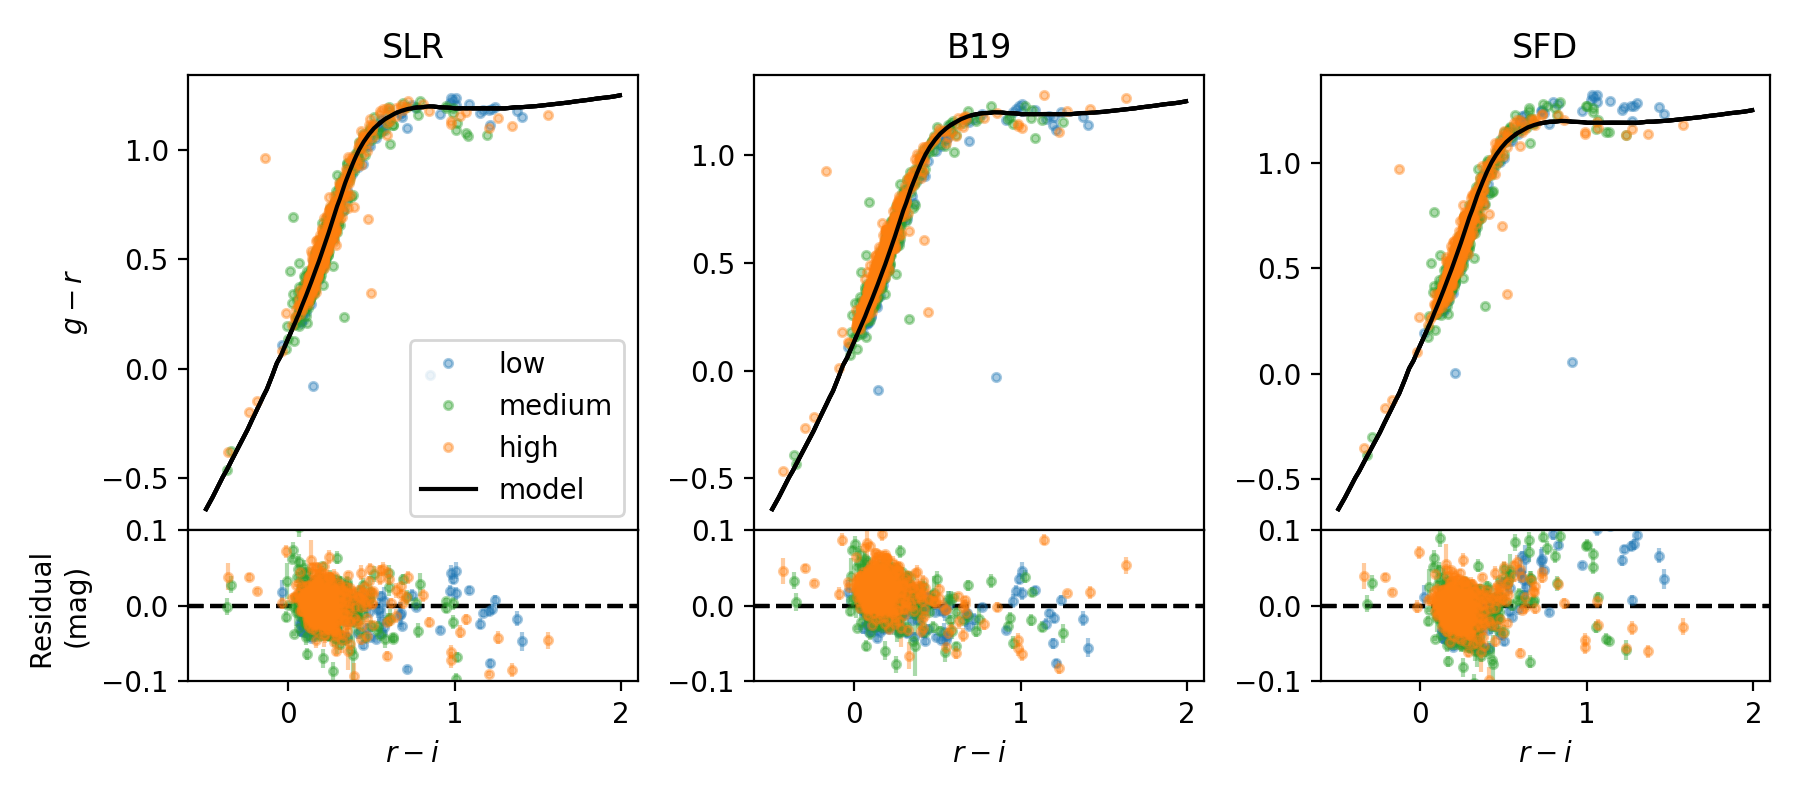

B19
2.617 1.971
2.271 1.682
B19
2.617 1.971
2.271 1.682
B19
2.617 1.971
2.271 1.682


In [10]:
locus_range_plotter(dd,ee,bb,ss)
#plt.savefig('figs/ext_compare/red_correction_range.pdf')

In [17]:
bb

[array([0.01, 0.02, 0.  , 0.01, 0.  , 0.  , 0.  , 0.04, 0.  , 0.  , 0.  ,
        0.  , 0.01, 0.04, 0.04, 0.  , 0.01, 0.04, 0.  , 0.  , 0.  , 0.  ,
        0.01, 0.  , 0.04, 0.  , 0.  , 0.  , 0.04, 0.  , 0.  , 0.04, 0.  ,
        0.04, 0.04, 0.  , 0.  , 0.04, 0.04, 0.04, 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.02, 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 0.02, 0.02,
        0.02, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.02, 0.  , 0.  , 0.  , 0.02, 0.  , 0.01, 0.  , 0.01, 0.01,
        0.01, 0.  , 0.01, 0.01, 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.01,
        0.01, 0.  , 0.01, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.01,
        0.  , 0.  , 0.  , 0.01, 0.  , 0.05, 0.05, 0.  , 0.  , 0.  , 0.01,
        0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.  , 0.01, 0.05, 0.05, 0.  ,
        0.05, 0.05, 0.01, 0.  , 0.05, 0.05, 0.05, 0.  , 0.  , 0.  , 0.  ],
       dtype=float32),
 array([1.2625

In [18]:
tonry = np.loadtxt('Tonry_splines.txt')
compare = np.array([['r-i','g-r']])   
raw = Make_colours(dd[2],tonry,compare,Extinction = 0, Tonry = True,B19=True)
colours = Make_colours(dd[2],tonry,compare,Extinction = 1, Tonry = True,B19=True)

B19
20.617 -1.971
B19
20.617 -1.971


<IPython.core.display.Javascript object>


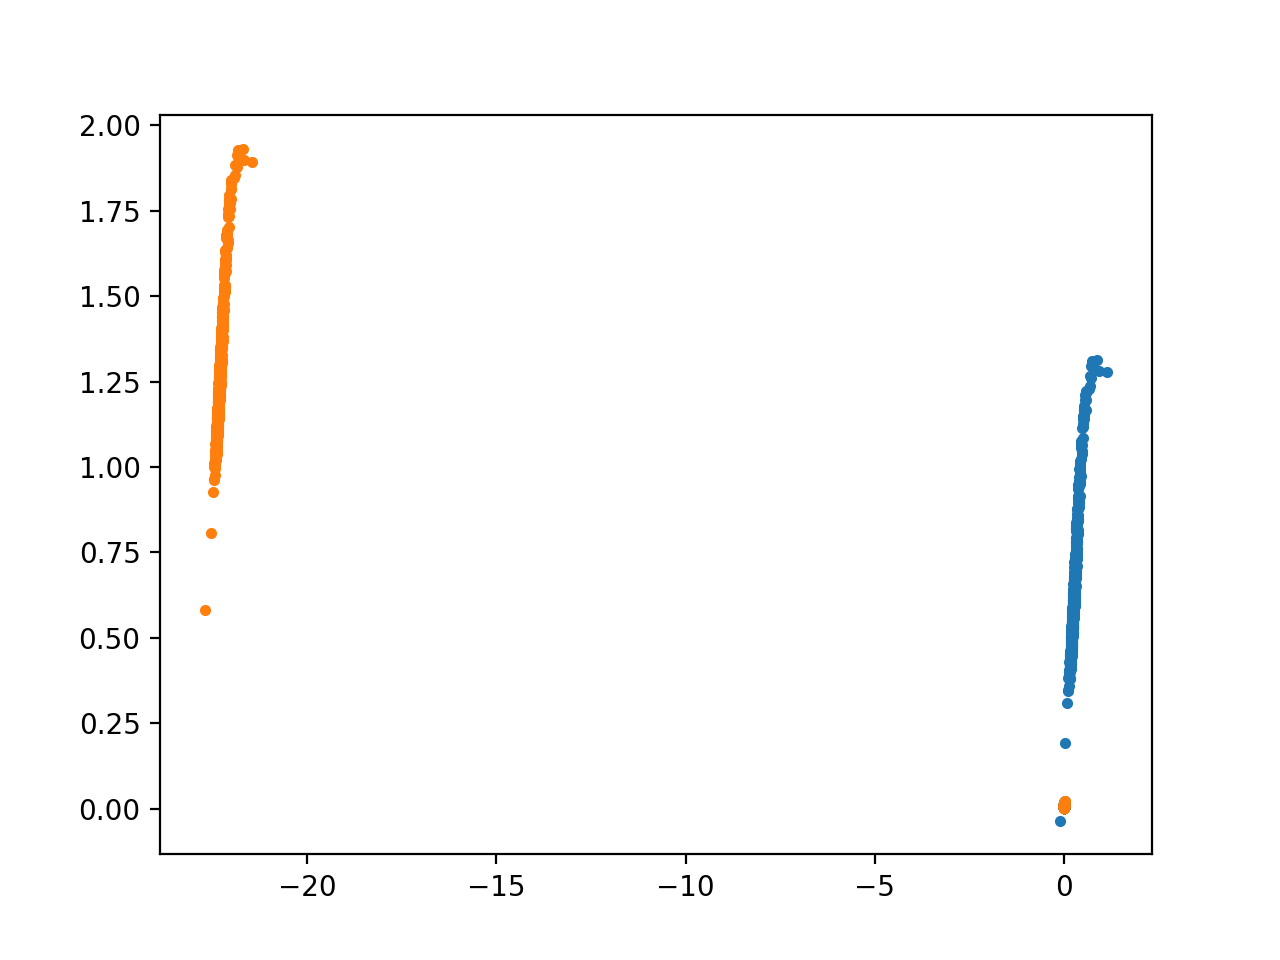

In [28]:
plt.figure()
plt.plot(raw['obs r-i'].flatten(),raw['obs g-r'].flatten(),'.')
plt.plot(colours['obs r-i'].flatten(),colours['obs g-r'].flatten(),'.')

In [21]:
colours['obs r-i'] - raw['obs r-i']

array([[-22.588, -22.588, -22.588, ..., -22.588, -22.588, -22.588],
       [  0.   ,   0.   ,   0.   , ...,   0.   ,   0.   ,   0.   ]])

In [42]:
d[2].to_csv('output/high_ext_test_sources.csv',index=False)

In [56]:
np.nanmedian(bb[2])


0.19999999

In [55]:
np.nanmedian(ss[2])

0.19302687

In [27]:
ax_dict['A'].plot(sf)

<IPython.core.display.Javascript object>


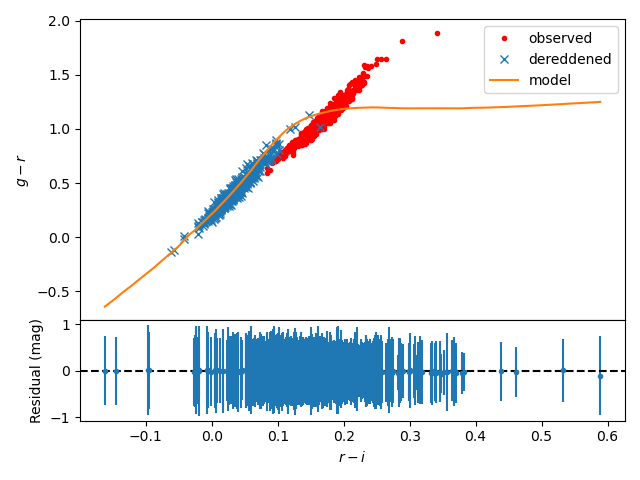

In [6]:
compare = np.array([['r-i','g-r']])   

gs = gridspec.GridSpec(4, 1)
#print(max(dat['rMeanPSFMag'] - dat['iMeanPSFMag']))
colours = Make_colours(dat,tonry,compare,Extinction = highb19[:,-1], Tonry = True)
rawc = Make_colours(dat,tonry,compare,Extinction = 0, Tonry = True)
dist = Calculate_distance(np.array([colours['obs r-i'][0],colours['obs g-r'][0]]), np.array([tonry[:,0],tonry[:,1]]))
fig = plt.figure()
fig.add_subplot(gs[0:3,0])
plt.plot(rawc['obs r-i'][0],rawc['obs g-r'][0],'r.',label='observed')
plt.plot(colours['obs r-i'][0],colours['obs g-r'][0],'x',label='dereddened')
plt.plot(colours['mod r-i'],colours['mod g-r'],label='model')
#print(np.nanmax(colours['obs r-i']))
plt.legend()
plt.ylabel('$g-r$')

fig.add_subplot(gs[3,0])
plt.axhline(0,color='k',ls='--')
plt.errorbar(colours['obs r-i'][0],dist,yerr=colours['obs g-r'][1],fmt='.')
plt.ylabel('Residual (mag)')
plt.xlabel('$r-i$')
plt.tight_layout()
plt.subplots_adjust(hspace=0)

In [7]:
x[:,np.newaxis]-y[np.newaxis,:]

array([[  0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11, -12,
        -13, -14, -15, -16, -17, -18, -19],
       [  1,   0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11,
        -12, -13, -14, -15, -16, -17, -18],
       [  2,   1,   0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10,
        -11, -12, -13, -14, -15, -16, -17],
       [  3,   2,   1,   0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9,
        -10, -11, -12, -13, -14, -15, -16],
       [  4,   3,   2,   1,   0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,
         -9, -10, -11, -12, -13, -14, -15],
       [  5,   4,   3,   2,   1,   0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,
         -8,  -9, -10, -11, -12, -13, -14],
       [  6,   5,   4,   3,   2,   1,   0,  -1,  -2,  -3,  -4,  -5,  -6,
         -7,  -8,  -9, -10, -11, -12, -13],
       [  7,   6,   5,   4,   3,   2,   1,   0,  -1,  -2,  -3,  -4,  -5,
         -6,  -7,  -8,  -9, -10, -11, -12],
       [  8,   7,   6,   5,   4,   3,   2,   1,   0,  -1,  -2,  

<IPython.core.display.Javascript object>


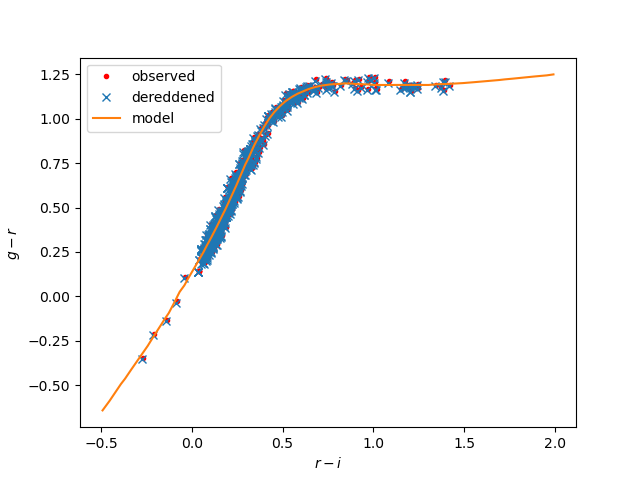

In [5]:
ra = 156.23395 
dec = 60.25760

name = 'no_dust'
ps1_query = """
            select 
            o.raMean, o.decMean,o.gMeanPSFMag,o.rMeanPSFMag,
            o.iMeanPSFMag,o.zMeanPSFMag,o.yMeanPSFMag,
            o.gMeanPSFMagErr,o.rMeanPSFMagErr,
            o.iMeanPSFMagErr,o.zMeanPSFMagErr,o.yMeanPSFMagErr
            into mydb.[{dbname}]
            from fGetNearbyObjEq({ra},{dec},{rad}) x
            JOIN MeanObjectView o on o.ObjID=x.ObjId
            LEFT JOIN StackObjectAttributes AS soa ON soa.objID = x.objID
            WHERE o.nDetections > 5
            AND soa.primaryDetection > 0
            AND o.{band}MeanPSFMag < {maglim}
            """
query = ps1_query.format(dbname=name,ra=ra,
                          dec=dec,rad=.5*60,
                          band='g',maglim='19')
try:
    jobs.drop_table_if_exists(name)
except:
    pass
jobs.quick(query)
tab = jobs.get_table(name,format='CSV').to_pandas()

ind = ((tab.gMeanPSFMag.values > -800) & (tab.rMeanPSFMag.values > -800) & 
       (tab.iMeanPSFMag.values > -800) & (tab.zMeanPSFMag.values > -800))
tab = tab.iloc[ind]
gr = (tab.gMeanPSFMag - tab.rMeanPSFMag).values
ri = (tab.rMeanPSFMag - tab.iMeanPSFMag).values
lowe,low = Tonry_reduce(tab,plot=True)

In [57]:
coords = SkyCoord(ra=low.raMean.values*u.deg,dec=low.decMean.values*u.deg)
sfd = SFDQuery()
lowsfd = sfd(coords)

bayestar = BayestarQuery(max_samples=1)
lowb19 = bayestar(coords)

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 20.426 s
  pix_info:   0.567 s
   samples:   6.054 s
      best:   5.413 s
       nan:   0.037 s
      sort:   8.197 s
       idx:   0.157 s


<IPython.core.display.Javascript object>


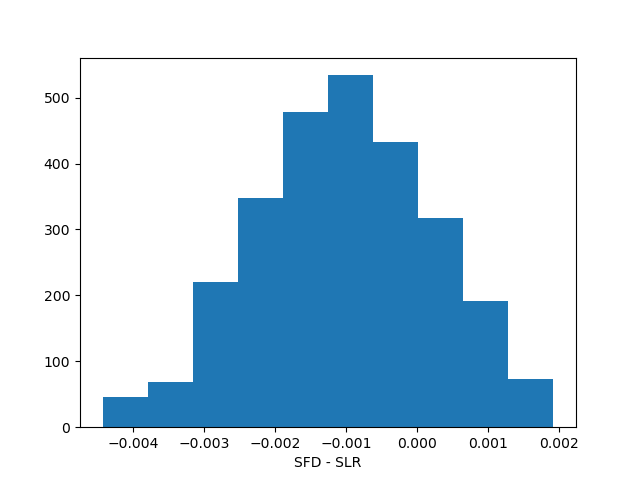

Text(0.5, 0, 'SFD - SLR')

In [15]:
diff = ebv-e*1.02
plt.figure()
plt.hist(diff)
plt.xlabel('SFD - SLR')

<IPython.core.display.Javascript object>


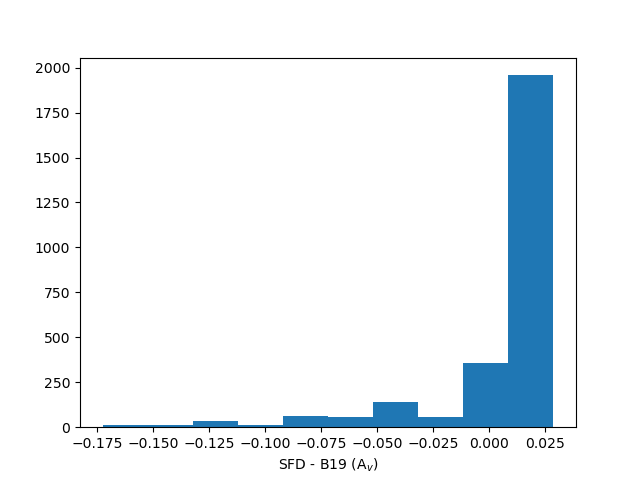

Text(0.5, 0, 'SFD - B19 (A$_v$)')

In [29]:
plt.figure()
plt.hist(ebv*2.742-np.nanmedian(b19,axis=1)*2.742)
plt.xlabel('SFD - B19 (A$_v$)')

<IPython.core.display.Javascript object>


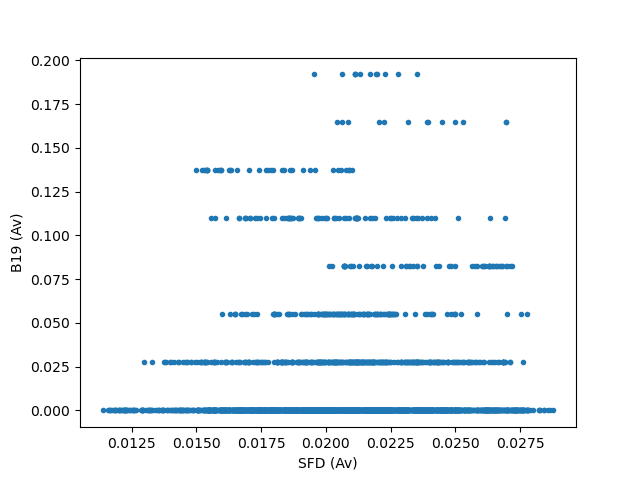

Text(0.5, 0, 'SFD (Av)')

In [53]:
plt.figure()
plt.plot(ebv*2.742,np.nanmedian(b19,axis=1)*2.742,'.')
plt.ylabel('B19 (Av)')
plt.xlabel('SFD (Av)')

In [ ]:
plt.figure()
plt.hist(ebv*2.742-np.nanmedian(b19,axis=1)*2.742)
plt.xlabel('SFD - B19 (A$_v$)')

<IPython.core.display.Javascript object>


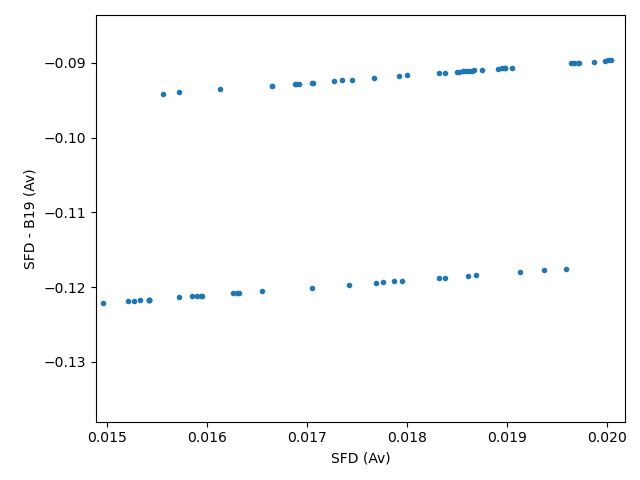

In [55]:
plt.figure()
plt.plot(ebv*2.742,ebv*2.742-np.nanmedian(b19,axis=1)*2.742,'.')
plt.ylabel('SFD - B19 (Av)')
plt.xlabel('SFD (Av)')
plt.tight_layout()

high extinction 

<IPython.core.display.Javascript object>


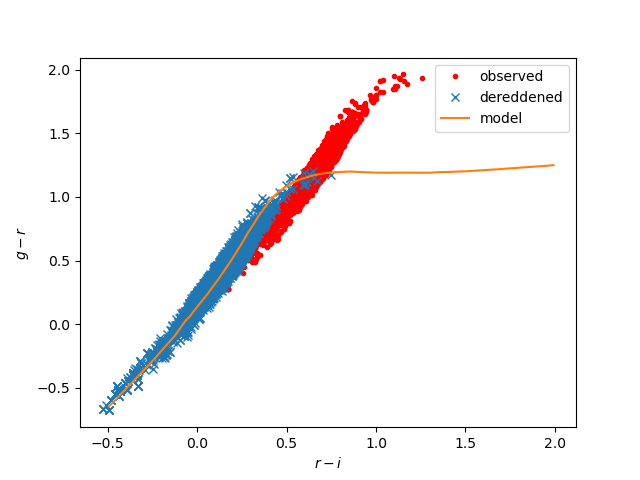

In [58]:
ra = 317.37900 
dec = 73.87250

name = 'no_dust'
ps1_query = """
            select 
            o.raMean, o.decMean,o.gMeanPSFMag,o.rMeanPSFMag,
            o.iMeanPSFMag,o.zMeanPSFMag,o.yMeanPSFMag,
            o.gMeanPSFMagErr,o.rMeanPSFMagErr,
            o.iMeanPSFMagErr,o.zMeanPSFMagErr,o.yMeanPSFMagErr
            into mydb.[{dbname}]
            from fGetNearbyObjEq({ra},{dec},{rad}) x
            JOIN MeanObjectView o on o.ObjID=x.ObjId
            LEFT JOIN StackObjectAttributes AS soa ON soa.objID = x.objID
            WHERE o.nDetections > 5
            AND soa.primaryDetection > 0
            AND o.{band}MeanPSFMag < {maglim}
            """
query = ps1_query.format(dbname=name,ra=ra,
                          dec=dec,rad=1*60,
                          band='g',maglim='19')
try:
    jobs.drop_table_if_exists(name)
except:
    pass
jobs.quick(query)
tab = jobs.get_table(name,format='CSV').to_pandas()

ind = ((tab.gMeanPSFMag.values > -800) & (tab.rMeanPSFMag.values > -800) & 
       (tab.iMeanPSFMag.values > -800) & (tab.zMeanPSFMag.values > -800))
tab = tab.iloc[ind]
gr = (tab.gMeanPSFMag - tab.rMeanPSFMag).values
ri = (tab.rMeanPSFMag - tab.iMeanPSFMag).values
highe,high = Tonry_reduce(tab,plot=True)

In [59]:
coords = SkyCoord(ra=high.raMean.values*u.deg,dec=high.decMean.values*u.deg)
sfd = SFDQuery()
highsfd = sfd(coords)

bayestar = BayestarQuery(max_samples=1)
highb19 = bayestar(coords)

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 19.352 s
  pix_info:   0.562 s
   samples:   5.756 s
      best:   5.091 s
       nan:   0.034 s
      sort:   7.742 s
       idx:   0.168 s


<IPython.core.display.Javascript object>


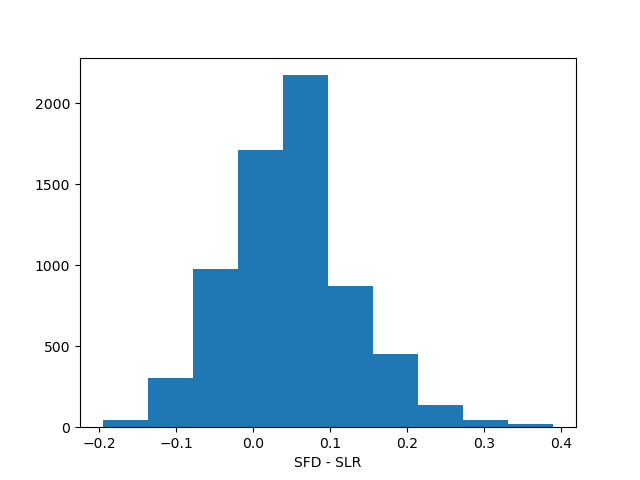

Text(0.5, 0, 'SFD - SLR')

In [41]:
diff = ebv-e
plt.figure()
plt.hist(diff)
plt.xlabel('SFD - SLR')

<IPython.core.display.Javascript object>


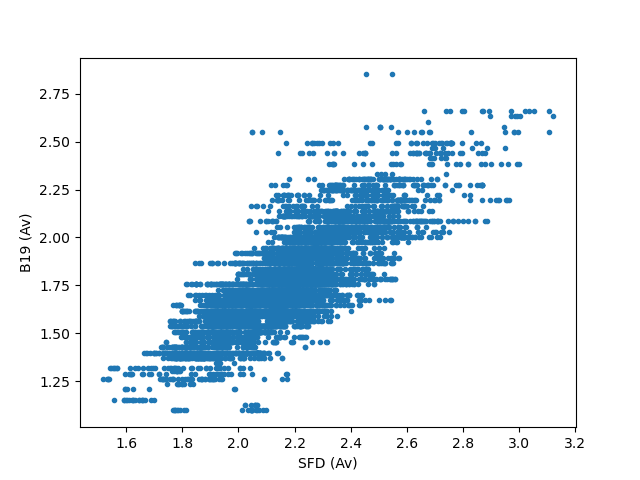

Text(0.5, 0, 'SFD (Av)')

In [42]:
plt.figure()
plt.plot(ebv*2.742,np.nanmedian(b19,axis=1)*2.742,'.')
plt.ylabel('B19 (Av)')
plt.xlabel('SFD (Av)')

<IPython.core.display.Javascript object>


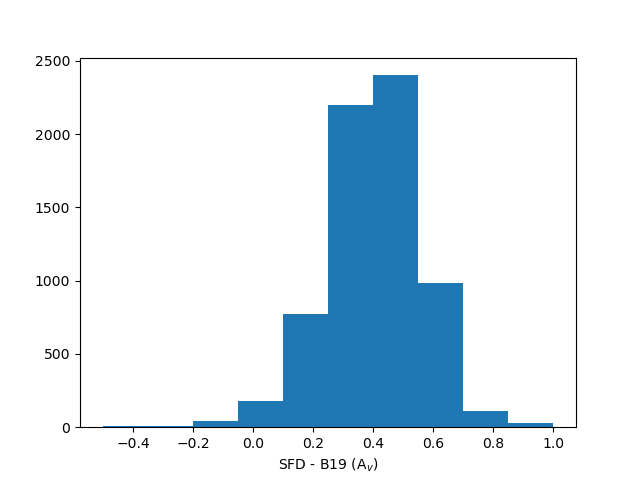

Text(0.5, 0, 'SFD - B19 (A$_v$)')

In [43]:
plt.figure()
plt.hist(ebv*2.742-np.nanmedian(b19,axis=1)*2.742)
plt.xlabel('SFD - B19 (A$_v$)')

<IPython.core.display.Javascript object>


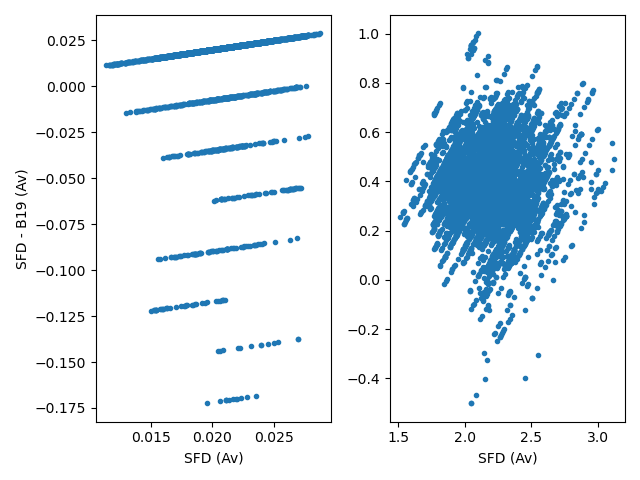

In [62]:

plt.figure()
plt.subplot(121)
plt.plot(lowsfd*2.742,lowsfd*2.742-np.nanmedian(lowb19,axis=1)*2.742,'.')
plt.ylabel('SFD - B19 (Av)')
plt.xlabel('SFD (Av)')

plt.subplot(122)
plt.plot(highsfd*2.742,highsfd*2.742-np.nanmedian(highb19,axis=1)*2.742,'.')
plt.xlabel('SFD (Av)')
plt.tight_layout()

In [35]:
bayestar = BayestarQuery(max_samples=10)

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 32.315 s
  pix_info:   0.415 s
   samples:  20.795 s
      best:   5.114 s
       nan:   0.166 s
      sort:   5.705 s
       idx:   0.120 s


In [37]:
highb19 = bayestar(coords)

In [38]:
highb19.shape

(6732, 120)

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 30.662 s
  pix_info:   0.379 s
   samples:  19.847 s
      best:   4.149 s
       nan:   0.029 s
      sort:   6.116 s
       idx:   0.141 s


<IPython.core.display.Javascript object>


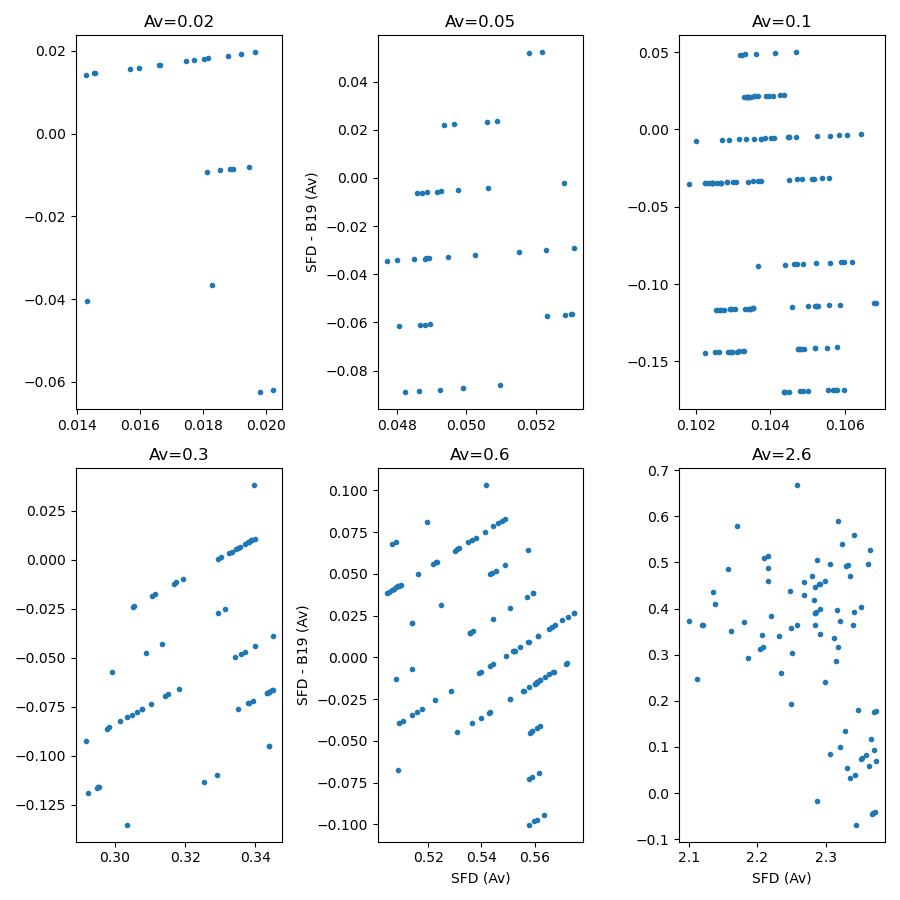

In [41]:
ras = [156.23395,239.67243,285.16583,280.56490,89.85051,317.37900]
decs = [60.25760, 58.13691,67.10030,75.39556,71.65306,73.87250]
labels = ['Av=0.02','Av=0.05','Av=0.1','Av=0.3','Av=0.6','Av=2.6']

sf = np.array([])
bb = np.array([])
ss = np.array([])
sfd = SFDQuery()
bayestar = BayestarQuery(max_samples=10)

plt.figure(figsize=(9,9))
for i in range(len(ras)):
    query = ps1_query.format(dbname=name,ra=ras[i],
                              dec=decs[i],rad=.1*60,
                              band='g',maglim='19')
    try:
        jobs.drop_table_if_exists(name)
    except:
        pass
    jobs.quick(query)
    tab = jobs.get_table(name,format='CSV').to_pandas()

    ind = ((tab.gMeanPSFMag.values > -800) & (tab.rMeanPSFMag.values > -800) & 
           (tab.iMeanPSFMag.values > -800) & (tab.zMeanPSFMag.values > -800))
    tab = tab.iloc[ind]
    gr = (tab.gMeanPSFMag - tab.rMeanPSFMag).values
    ri = (tab.rMeanPSFMag - tab.iMeanPSFMag).values
    e,dat = Tonry_reduce(tab,plot=False)
    
    coords = SkyCoord(ra=dat.raMean.values*u.deg,dec=dat.decMean.values*u.deg)

    highsfd = sfd(coords)
    sf = np.append(sf,highsfd.flatten())
    ss = np.append(ss,np.ones_like(highsfd.flatten())*e)
    highb19 = bayestar(coords)
    bb = np.append(bb,highb19[:,-1].flatten())
    plt.subplot(2,3,i+1)
    plt.plot(highsfd*2.742,highsfd*2.742-highb19[:,-1]*2.742,'.') 
    if (i ==1) | (i ==4):
        plt.ylabel('SFD - B19 (Av)')
    if i > 3:
        plt.xlabel('SFD (Av)')
    plt.title(labels[i])
plt.tight_layout()
#plt.savefig('B19_SDF_fields.pdf')

In [3]:
ras = [156.23395,239.67243,285.16583,280.56490,89.85051,317.37900]
decs = [60.25760, 58.13691,67.10030,75.39556,71.65306,73.87250]
labels = ['Av=0.02','Av=0.05','Av=0.1','Av=0.3','Av=0.6','Av=2.6']

scale = 1
offset = [[-1*scale,1*scale],[0,1*scale],[1*scale,1*scale],
          [-1*scale,0],[0,0],[1*scale,0],
          [-1*scale,-1*scale],[0,-1*scale],[1*scale,-1*scale]]
bayestar = BayestarQuery(max_samples=1)

sf = np.array([])
bb = np.array([])
ss = np.array([])
sfd = SFDQuery()


for i in range(len(ras)):
    for j in range(len(offset)):
        query = ps1_query.format(dbname=name,ra=ras[i]+offset[j][0],
                                  dec=decs[i]+offset[j][1],rad=.3*60,
                                  band='g',maglim='19')

        try:
            jobs.drop_table_if_exists(name)
        except:
            pass
        jobs.quick(query)
        tab = jobs.get_table(name,format='CSV').to_pandas()

        ind = ((tab.gMeanPSFMag.values > -800) & (tab.rMeanPSFMag.values > -800) & 
               (tab.iMeanPSFMag.values > -800) & (tab.zMeanPSFMag.values > -800) &
               (abs(tab.rMeanPSFMagErr.values) < 0.1) & (abs(tab.gMeanPSFMagErr.values) < 0.1) & 
               (abs(tab.iMeanPSFMagErr.values) < 0.1))
        tab = tab.iloc[ind]
        gr = (tab.gMeanPSFMag - tab.rMeanPSFMag).values
        ri = (tab.rMeanPSFMag - tab.iMeanPSFMag).values
            
        e,dat = Tonry_reduce(tab,plot=True)
        coords = SkyCoord(ra=dat.raMean.values*u.deg,dec=dat.decMean.values*u.deg)

        highsfd = sfd(coords)
        plt.title('$SLR_{ext}=$'+str(np.round(e[0],4)) + ', Average $SFD_{ext}=$'+str(np.round(np.nanmedian(highsfd),4)))
        plt.savefig('figs/ext_compare/pos{}_grid{}.png'.format(i,j))
        sf = np.append(sf,highsfd.flatten())
        ss = np.append(ss,np.ones_like(highsfd.flatten())*e)
        highb19 = bayestar(coords)
        bb = np.append(bb,highb19[:,-1].flatten())

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 12.708 s
  pix_info:   0.437 s
   samples:   3.362 s
      best:   3.290 s
       nan:   0.024 s
      sort:   5.470 s
       idx:   0.125 s


<IPython.core.display.Javascript object>


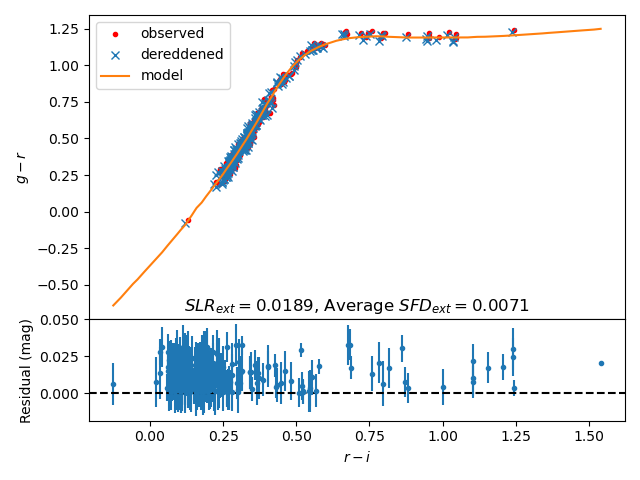

<IPython.core.display.Javascript object>


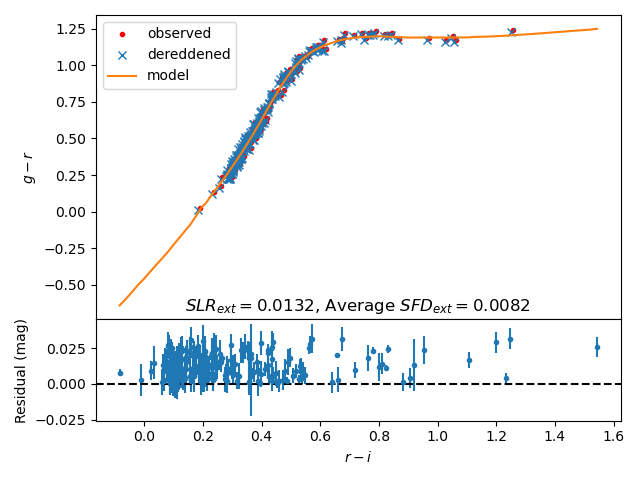

<IPython.core.display.Javascript object>


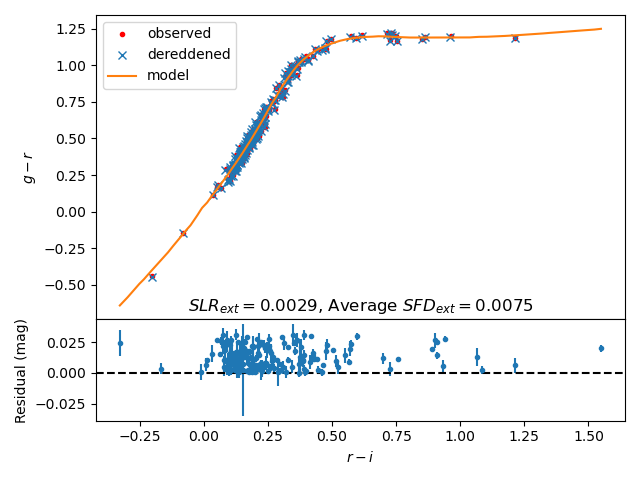

<IPython.core.display.Javascript object>


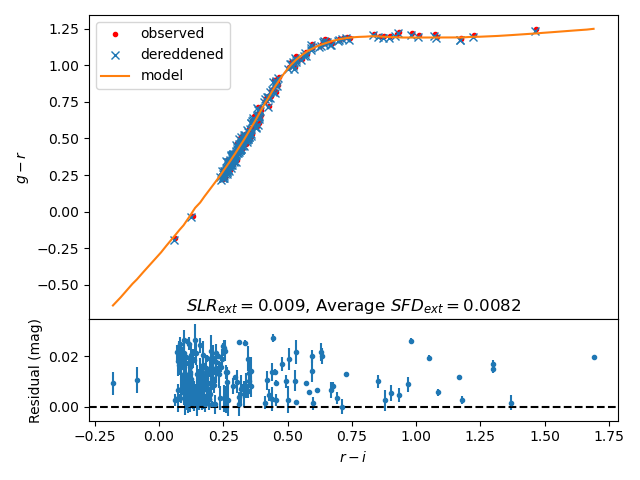

<IPython.core.display.Javascript object>


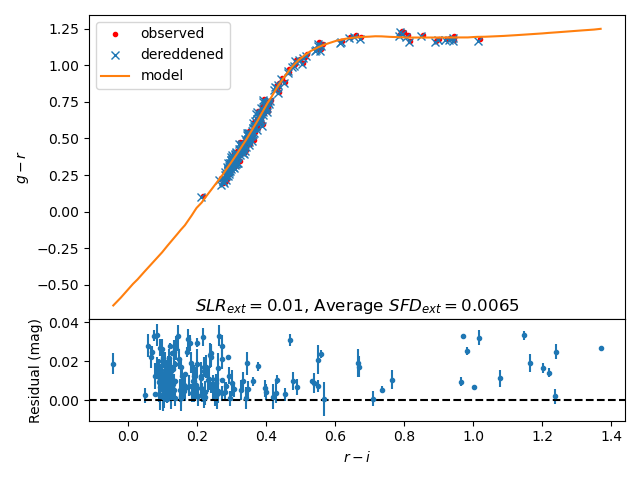

<IPython.core.display.Javascript object>


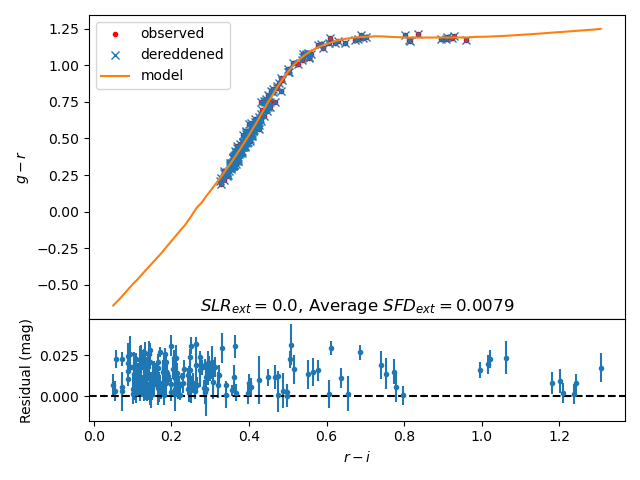

<IPython.core.display.Javascript object>


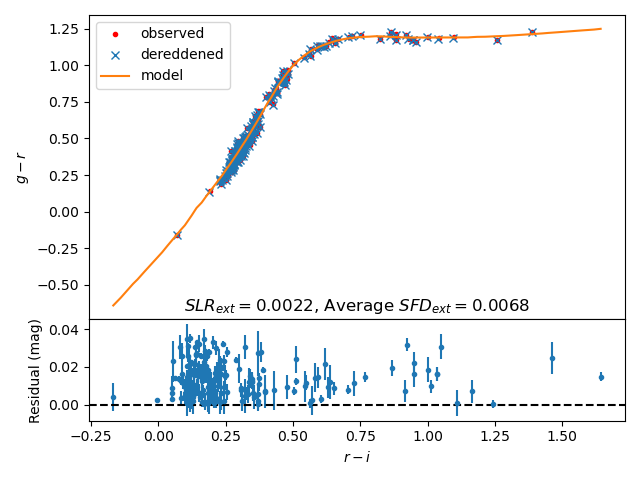

<IPython.core.display.Javascript object>


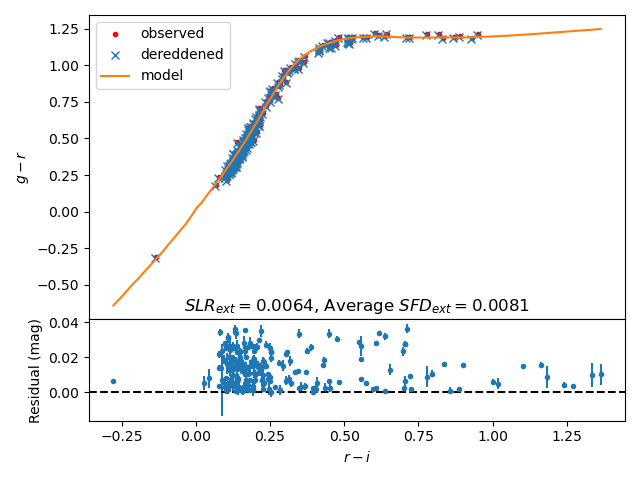

<IPython.core.display.Javascript object>


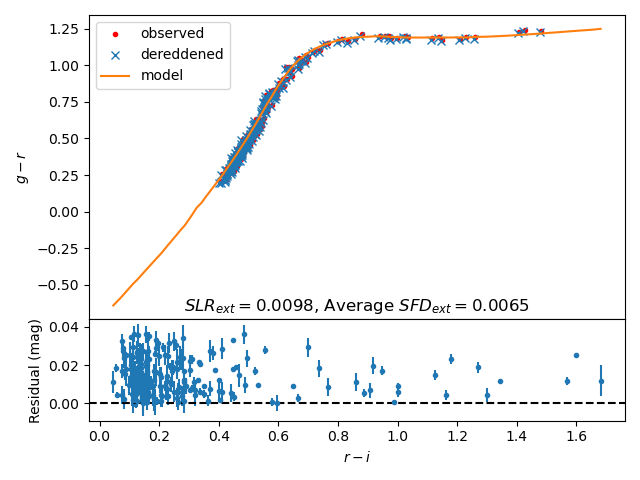

<IPython.core.display.Javascript object>


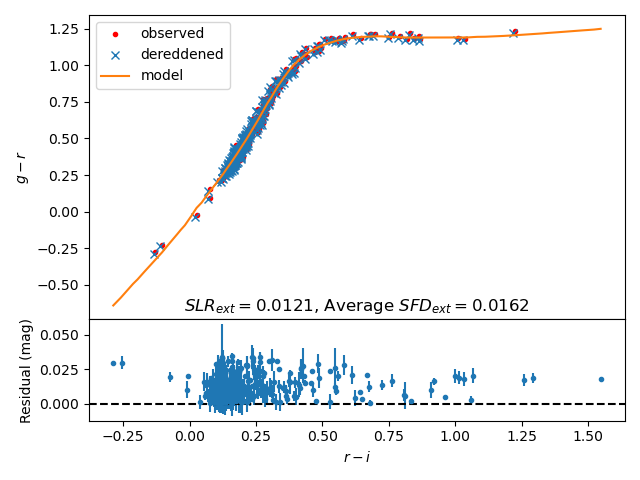

<IPython.core.display.Javascript object>


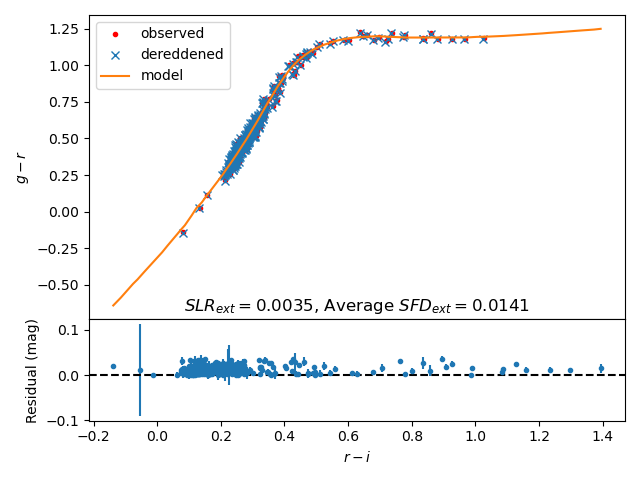

<IPython.core.display.Javascript object>


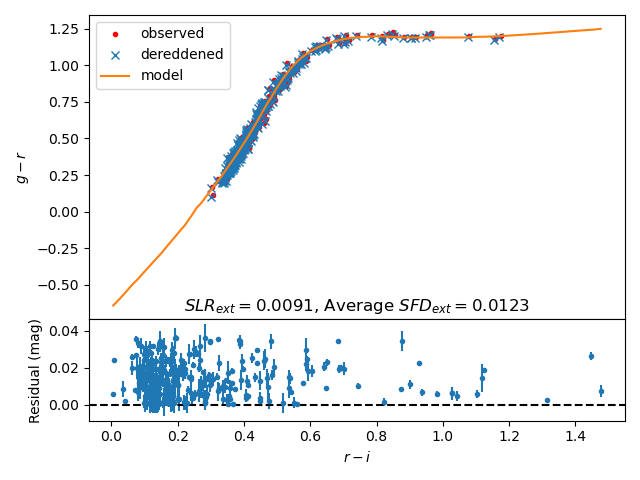

<IPython.core.display.Javascript object>


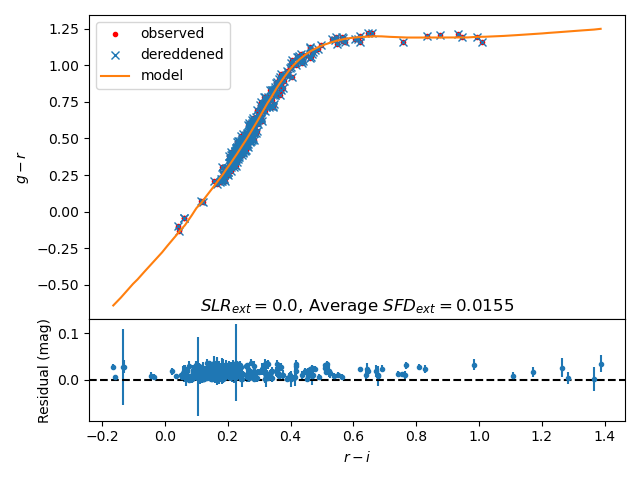

<IPython.core.display.Javascript object>


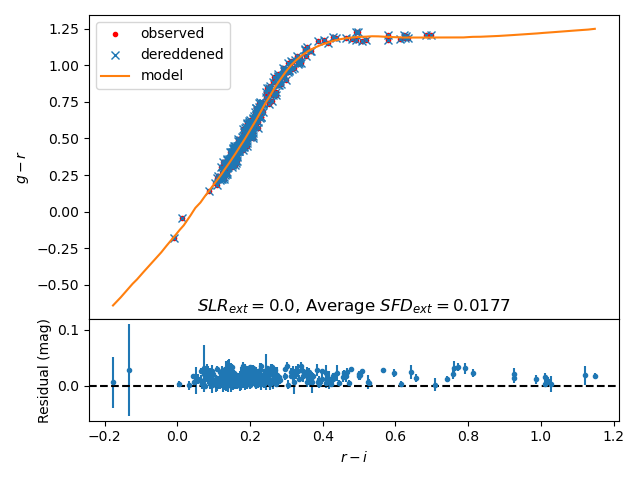

<IPython.core.display.Javascript object>


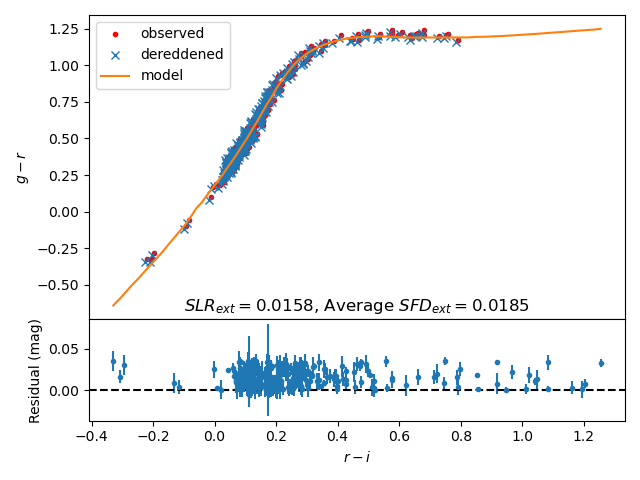

<IPython.core.display.Javascript object>


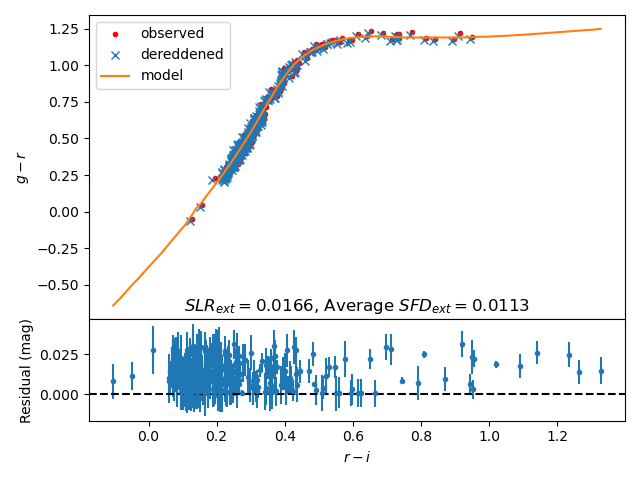

<IPython.core.display.Javascript object>


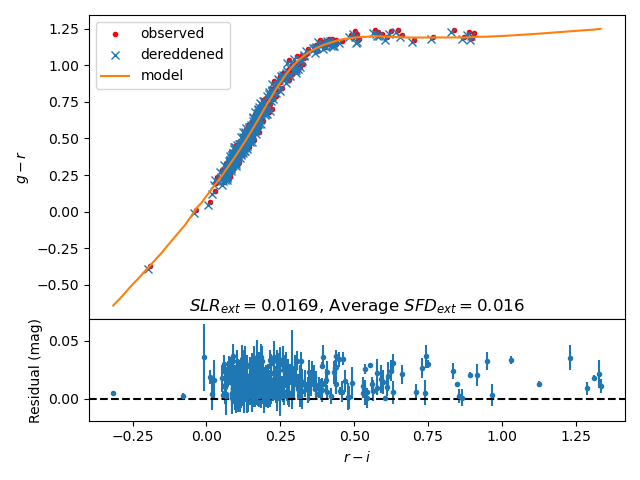

<IPython.core.display.Javascript object>


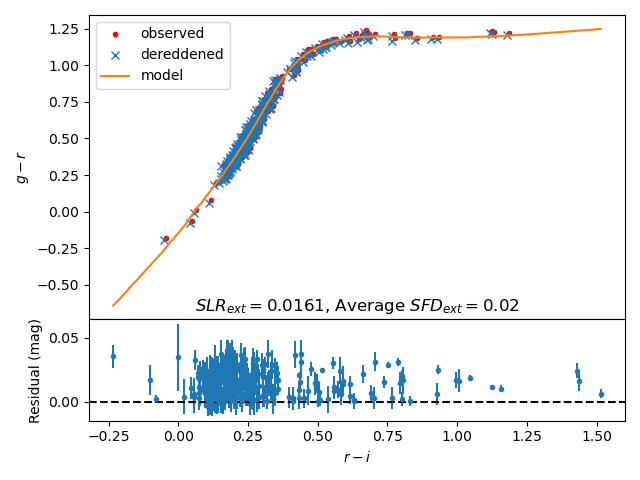

<IPython.core.display.Javascript object>


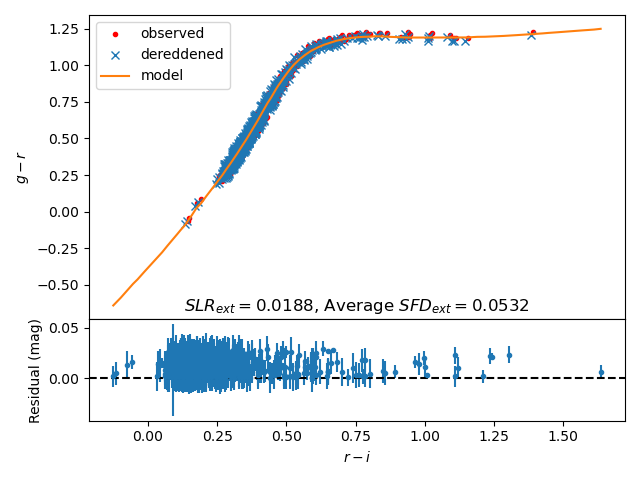

<IPython.core.display.Javascript object>


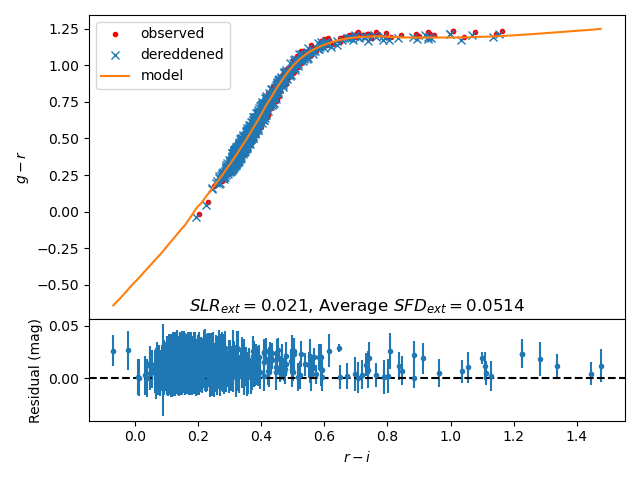

<IPython.core.display.Javascript object>


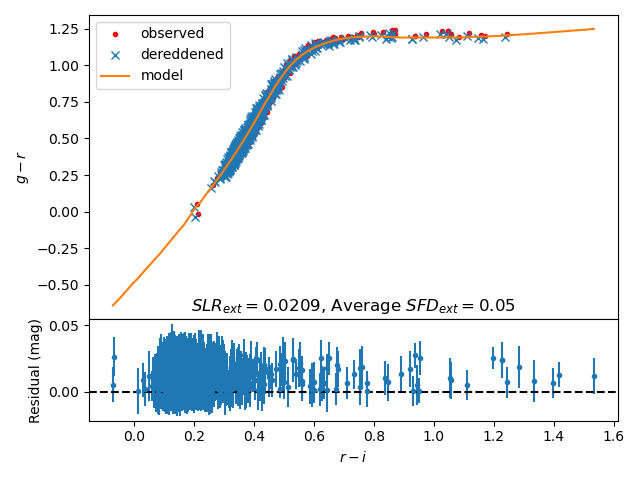

<IPython.core.display.Javascript object>


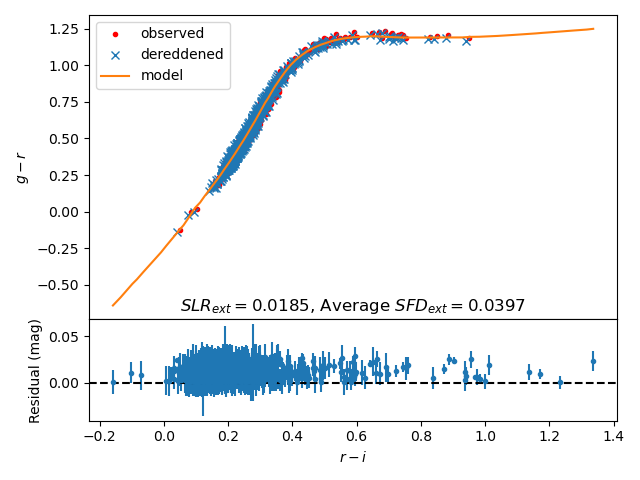

<IPython.core.display.Javascript object>


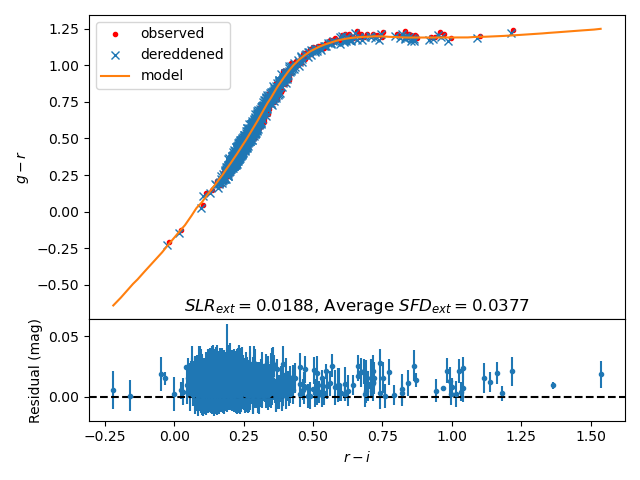

<IPython.core.display.Javascript object>


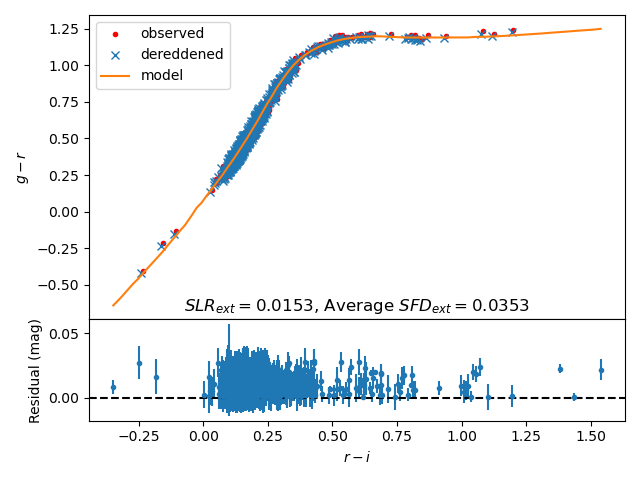

<IPython.core.display.Javascript object>


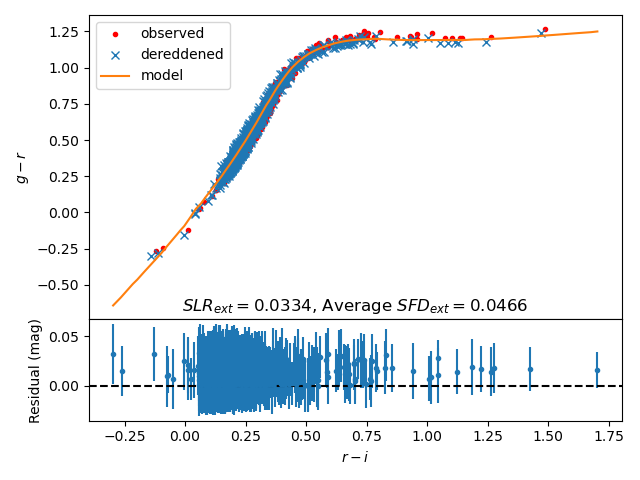

<IPython.core.display.Javascript object>


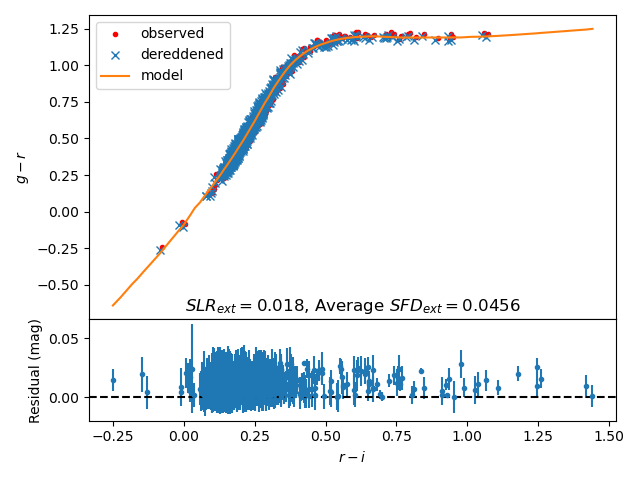

<IPython.core.display.Javascript object>


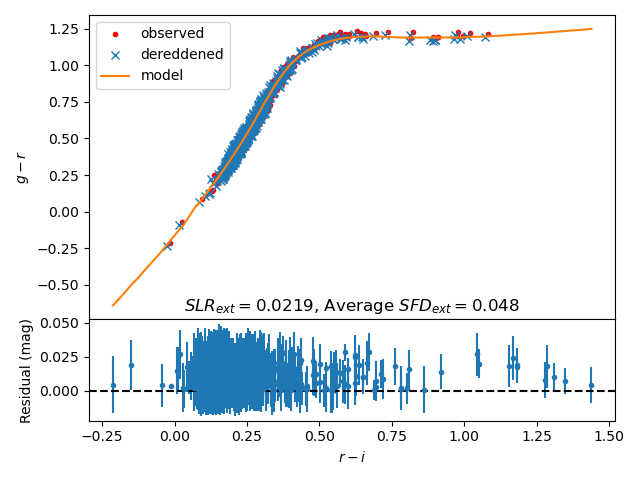

<IPython.core.display.Javascript object>


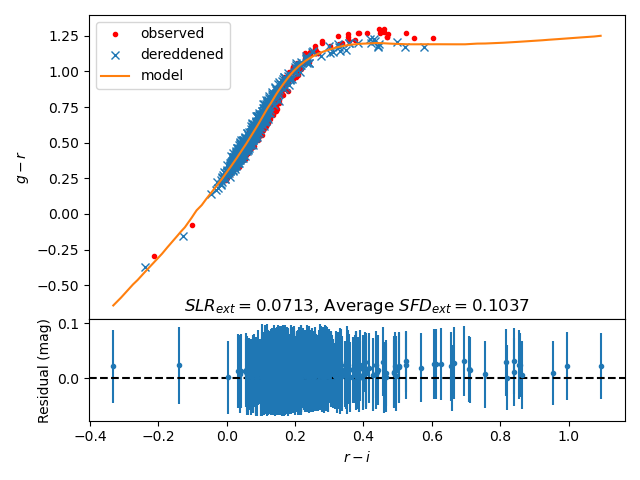

<IPython.core.display.Javascript object>


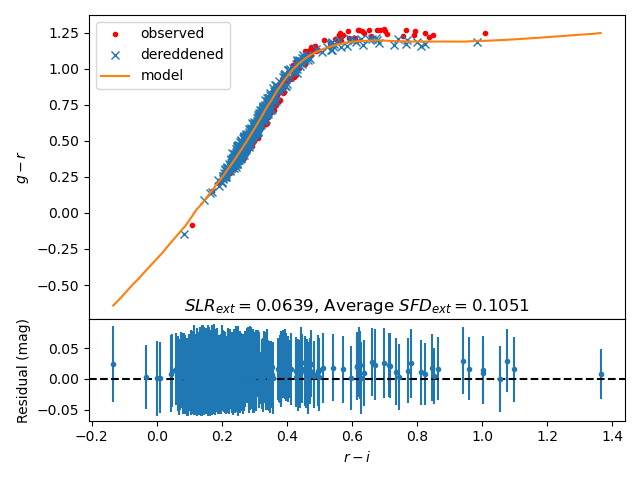

<IPython.core.display.Javascript object>


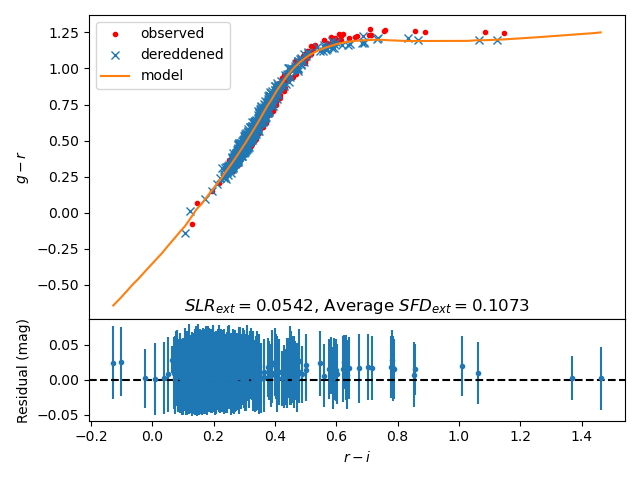

<IPython.core.display.Javascript object>


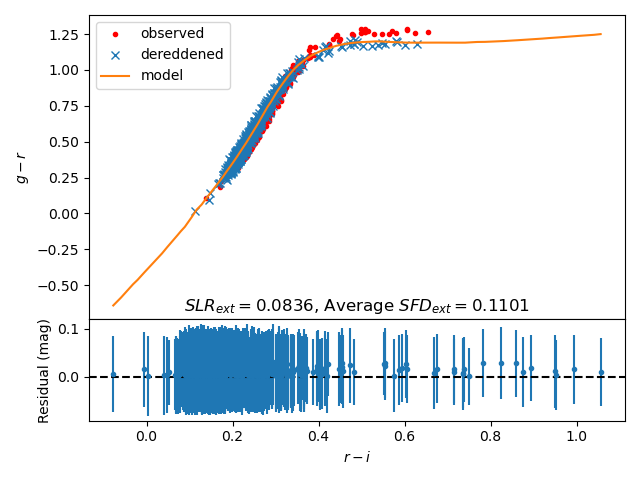

<IPython.core.display.Javascript object>


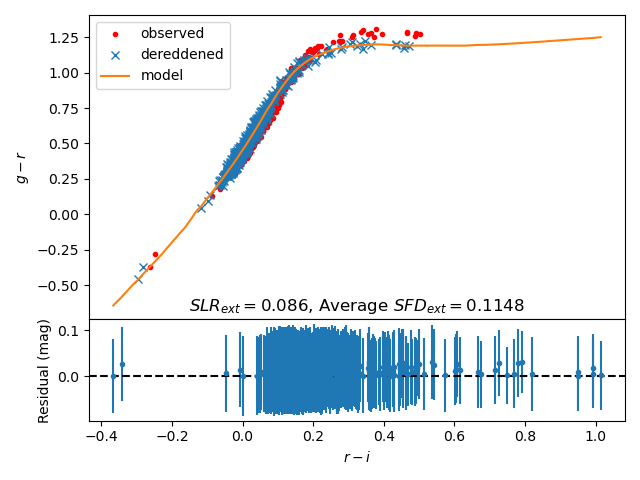

<IPython.core.display.Javascript object>


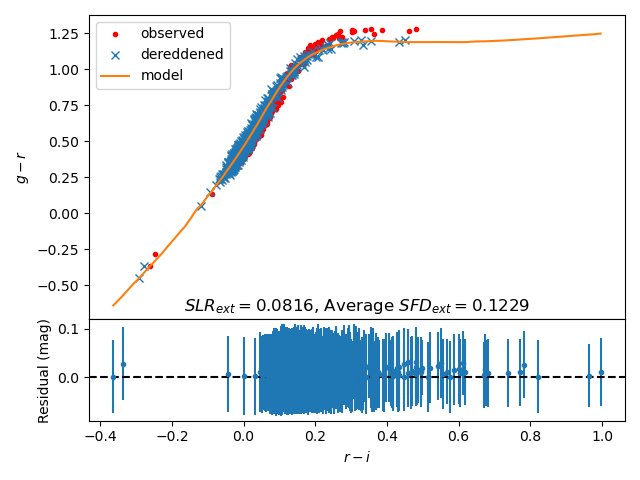

<IPython.core.display.Javascript object>


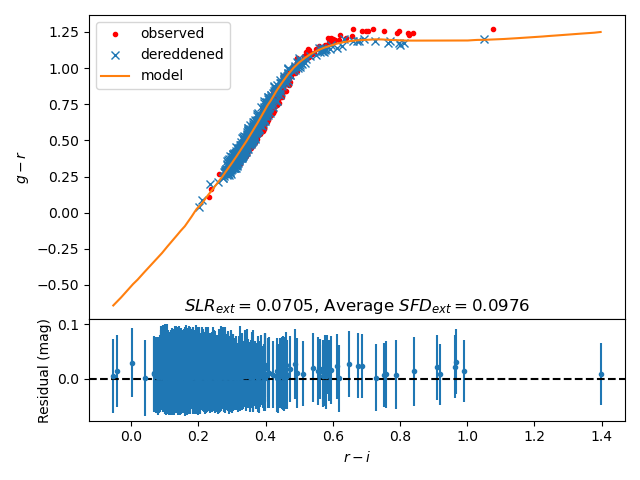

<IPython.core.display.Javascript object>


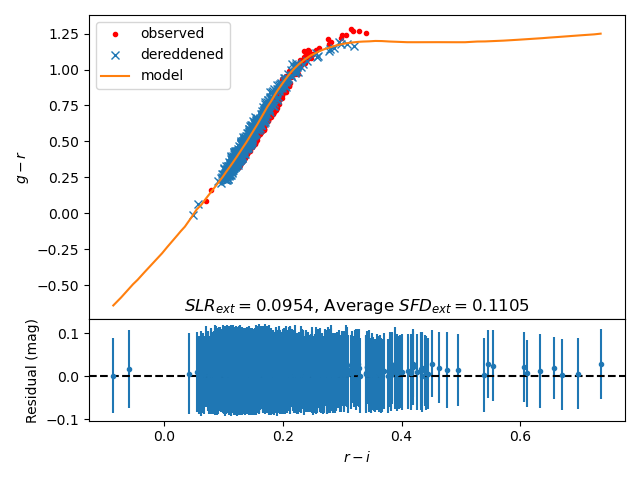

<IPython.core.display.Javascript object>


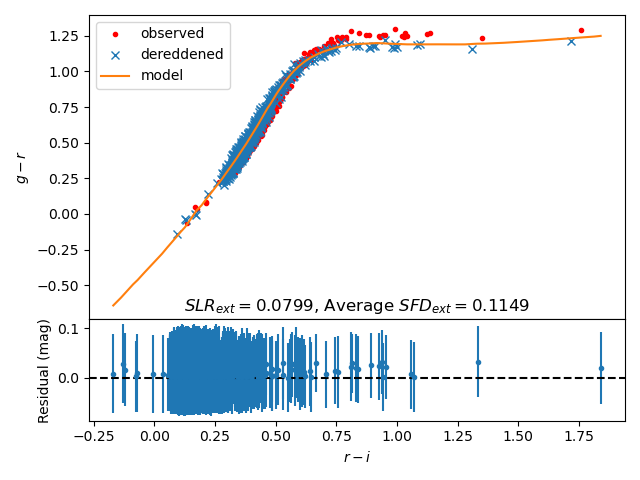

<IPython.core.display.Javascript object>


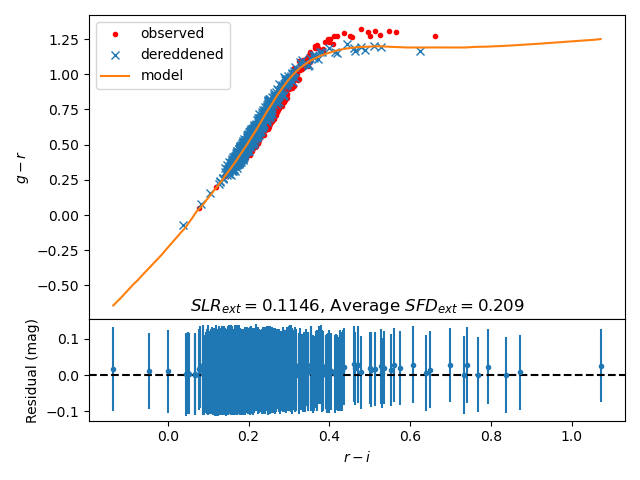

<IPython.core.display.Javascript object>


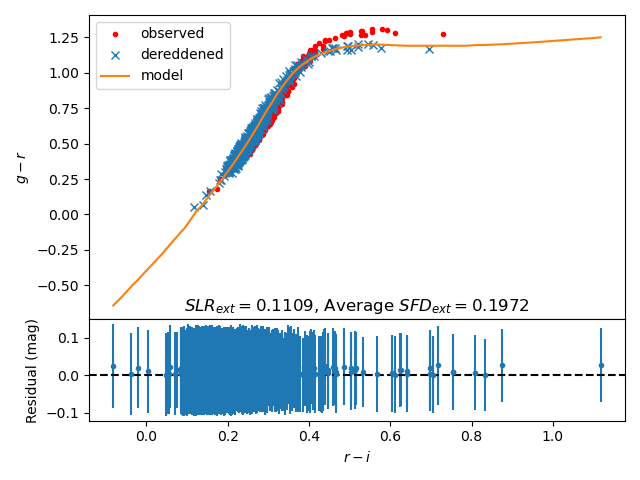

<IPython.core.display.Javascript object>


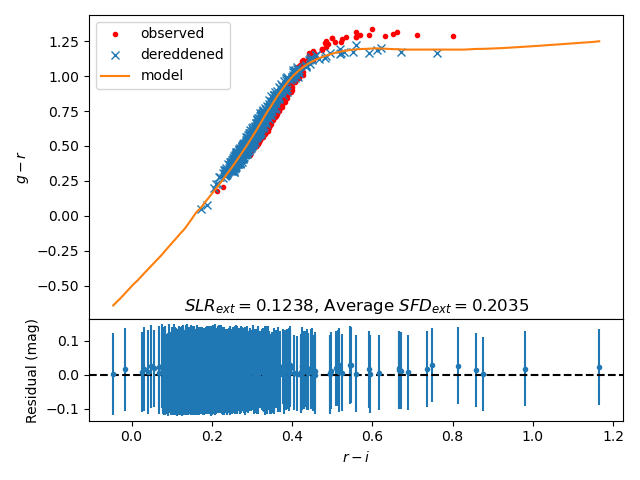

<IPython.core.display.Javascript object>


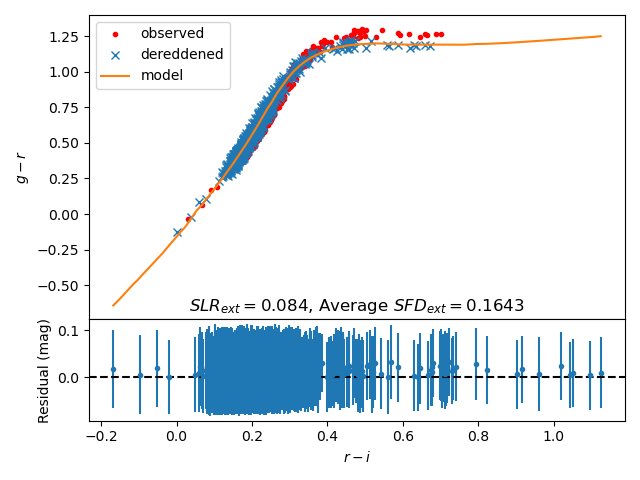

<IPython.core.display.Javascript object>


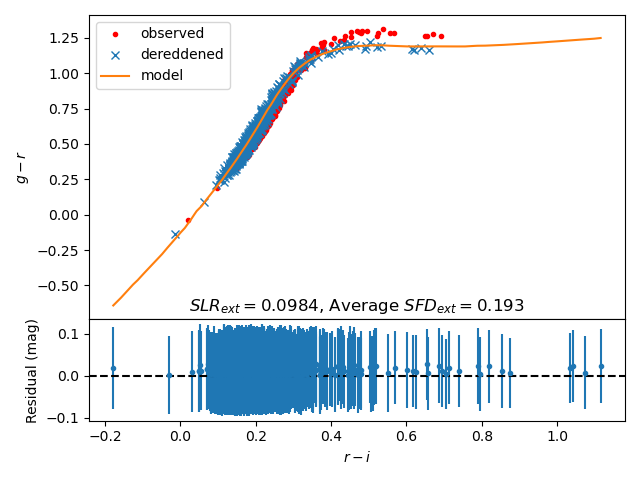

<IPython.core.display.Javascript object>


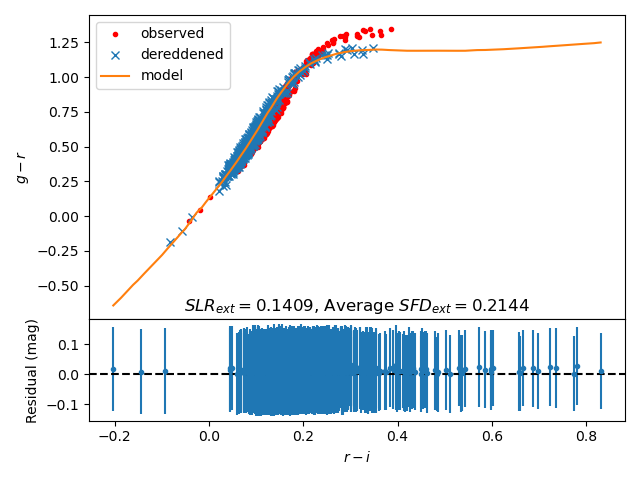

<IPython.core.display.Javascript object>


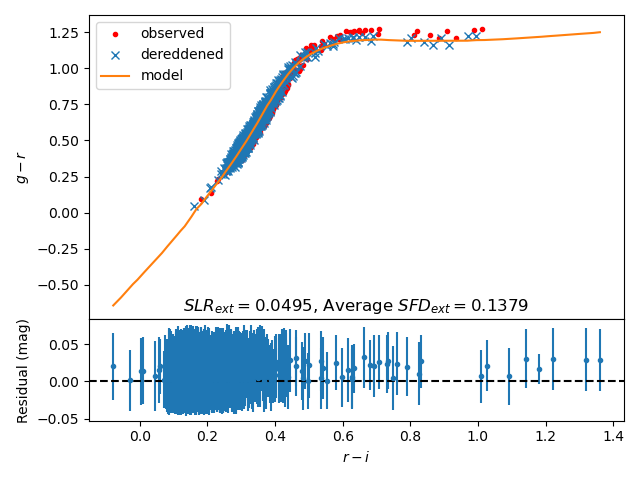

<IPython.core.display.Javascript object>


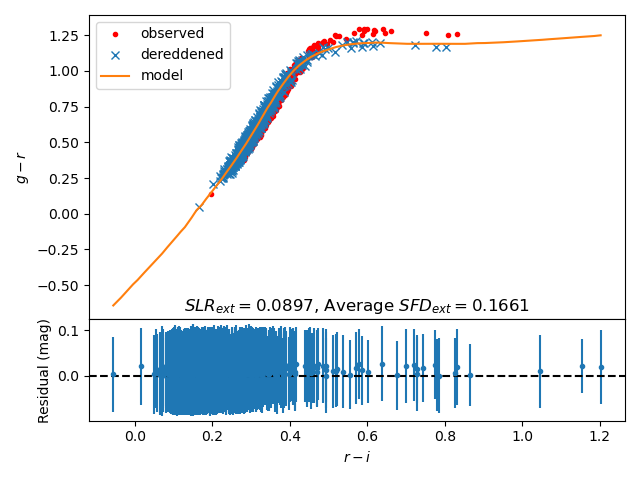

<IPython.core.display.Javascript object>


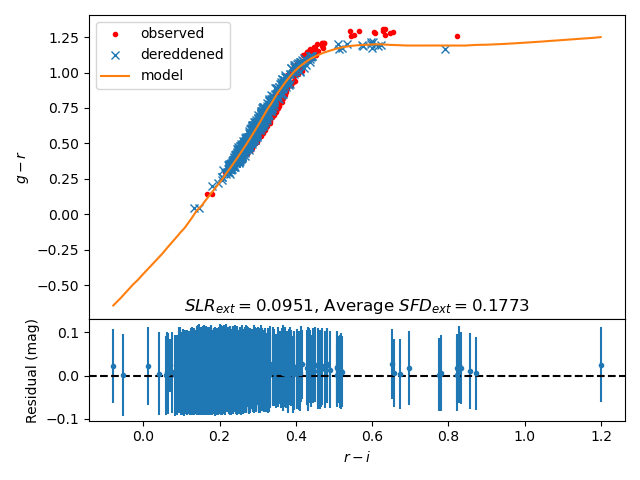

<IPython.core.display.Javascript object>


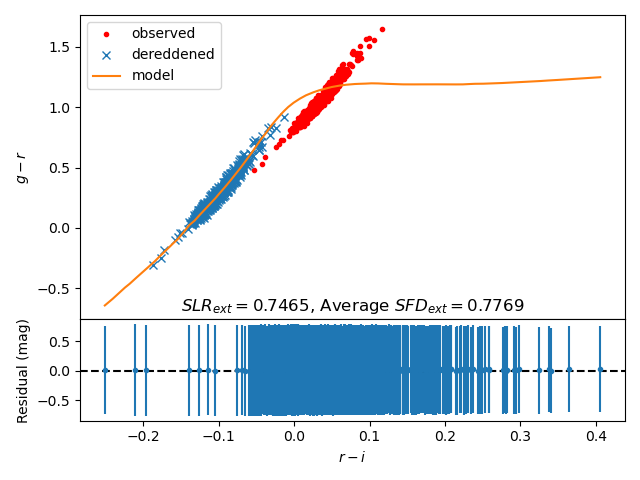

<IPython.core.display.Javascript object>


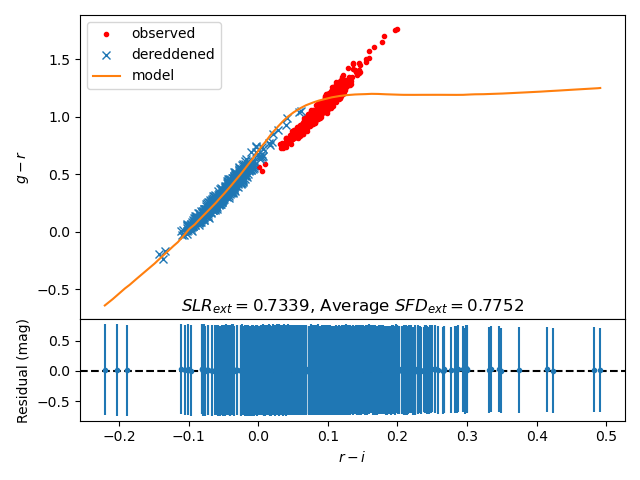

<IPython.core.display.Javascript object>


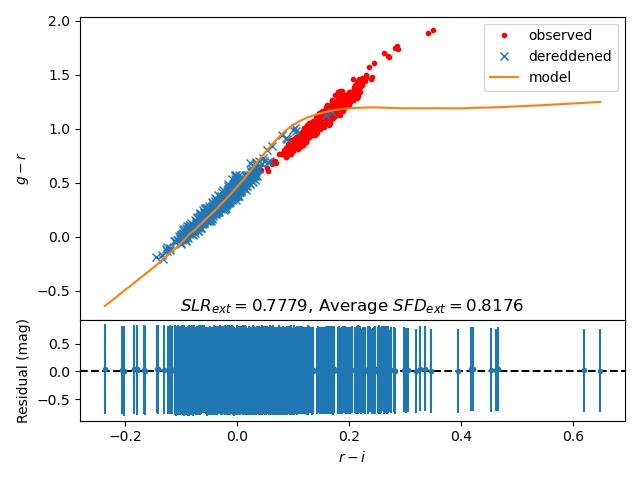

<IPython.core.display.Javascript object>


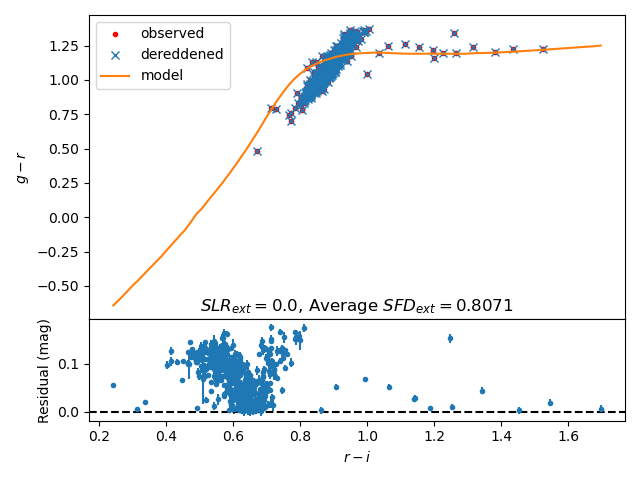

<IPython.core.display.Javascript object>


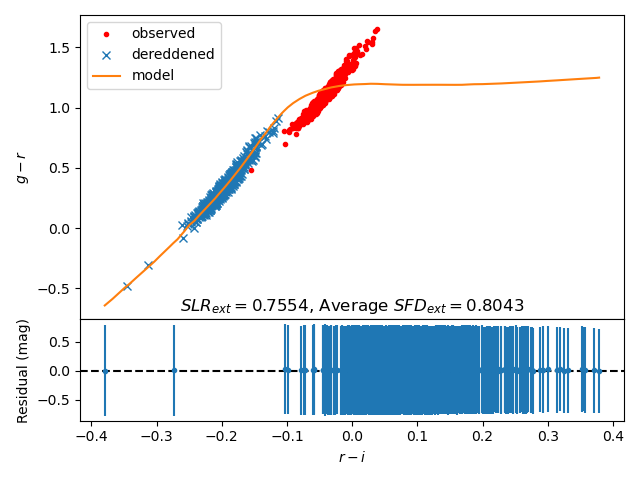

<IPython.core.display.Javascript object>


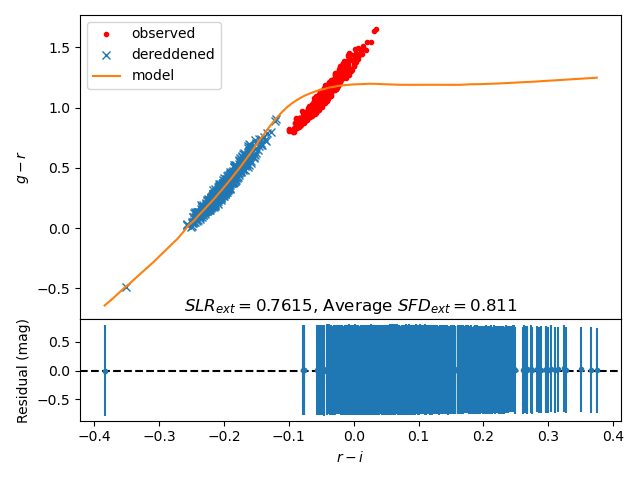

<IPython.core.display.Javascript object>


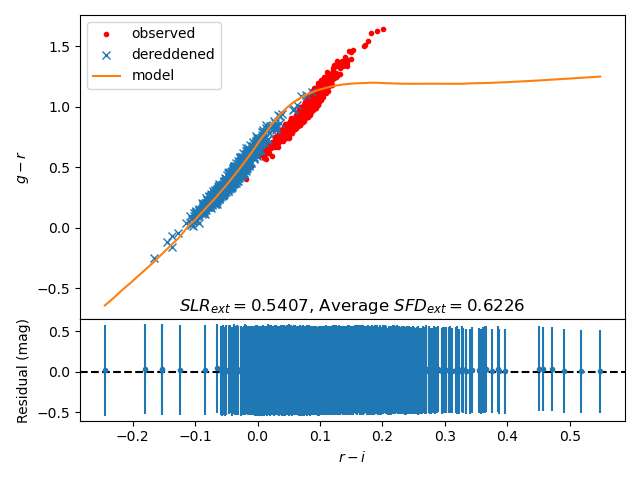

<IPython.core.display.Javascript object>


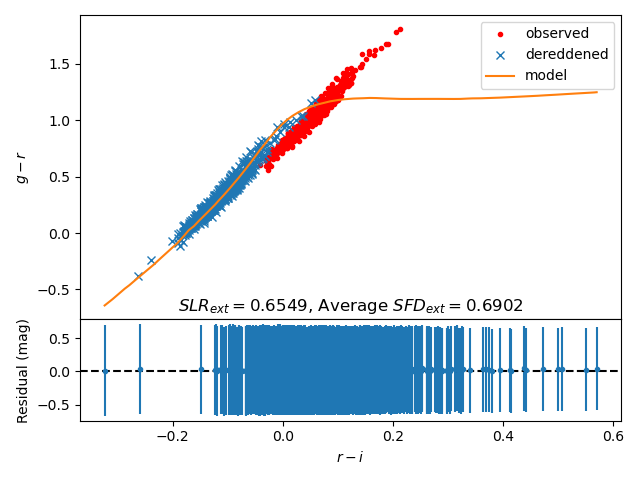

<IPython.core.display.Javascript object>


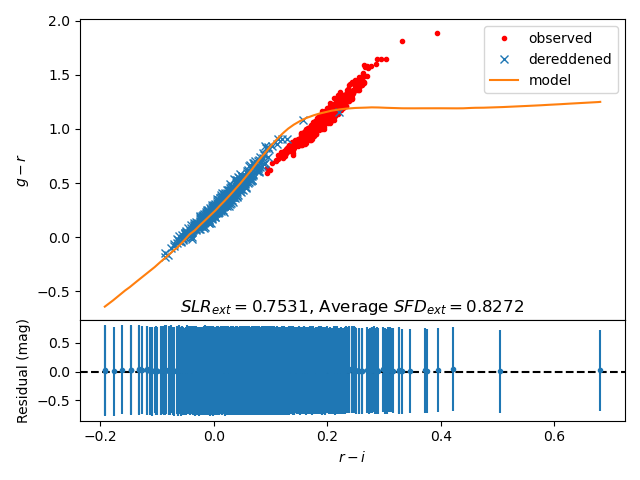

In [4]:
sf = np.array([])
bb = np.array([])
ss = np.array([])
sfd = SFDQuery()


for i in range(len(ras)):
    for j in range(len(offset)):
        query = ps1_query.format(dbname=name,ra=ras[i]+offset[j][0],
                                  dec=decs[i]+offset[j][1],rad=.3*60,
                                  band='g',maglim='19')

        try:
            jobs.drop_table_if_exists(name)
        except:
            pass
        jobs.quick(query)
        tab = jobs.get_table(name,format='CSV').to_pandas()

        ind = ((tab.gMeanPSFMag.values > -800) & (tab.rMeanPSFMag.values > -800) & 
               (tab.iMeanPSFMag.values > -800) & (tab.zMeanPSFMag.values > -800) &
               (abs(tab.rMeanPSFMagErr.values) < 0.1) & (abs(tab.gMeanPSFMagErr.values) < 0.1) & 
               (abs(tab.iMeanPSFMagErr.values) < 0.1))
        tab = tab.iloc[ind]
        gr = (tab.gMeanPSFMag - tab.rMeanPSFMag).values
        ri = (tab.rMeanPSFMag - tab.iMeanPSFMag).values
            
        e,dat = Tonry_reduce(tab,plot=True)
        coords = SkyCoord(ra=dat.raMean.values*u.deg,dec=dat.decMean.values*u.deg)

        highsfd = sfd(coords)
        plt.title('$SLR_{ext}=$'+str(np.round(e[0],4)) + ', Average $SFD_{ext}=$'+str(np.round(np.nanmedian(highsfd),4)))
        plt.savefig('figs/ext_compare/pos{}_grid{}.png'.format(i,j))
        sf = np.append(sf,highsfd.flatten())
        ss = np.append(ss,np.ones_like(highsfd.flatten())*e)
        highb19 = bayestar(coords)
        bb = np.append(bb,highb19[:,-1].flatten())

In [9]:
tonry

NameError: name 'tonry' is not defined

In [ ]:

plt.figure()
plt.plot(sf,bb,'.',label='B19')
plt.plot(sf,ss,'.',label='SLR')
plt.plot(sf,sf,label='SFD')

plt.ylabel('extinction')
plt.xlabel('SFD')

plt.legend()
plt.xlim(0,0.07)
plt.ylim(-.01,0.123)
plt.savefig('extinction_comparisons.pdf')

In [22]:
ras = [156.23395,239.67243,285.16583,280.56490,89.85051,317.37900]
decs = [60.25760, 58.13691,67.10030,75.39556,71.65306,73.87250]
labels = ['Av=0.02','Av=0.04','Av=0.12','Av=0.3','Av=0.5','Av=2.2']
name = 'no_dust'
plt.figure(figsize=(9,6))
for i in range(len(ras)):
    n = name+'_'+str(i)
    query = ps1_query.format(dbname=n,ra=ras[i],
                              dec=decs[i],rad=0.5*60,
                              band='g',maglim='19')
    try:
        #jobs.drop_table_if_exists(name)
        tab = jobs.get_table(n,format='CSV').to_pandas()
    except:
        pass
        jobs.quick(query)
        tab = jobs.get_table(n,format='CSV').to_pandas()

    ind = ((tab.gMeanPSFMag.values > -800) & (tab.rMeanPSFMag.values > -800) & 
           (tab.iMeanPSFMag.values > -800) & (tab.zMeanPSFMag.values > -800))
    tab = tab.iloc[ind]
    gr = (tab.gMeanPSFMag - tab.rMeanPSFMag).values
    ri = (tab.rMeanPSFMag - tab.iMeanPSFMag).values
    e,dat = Tonry_reduce(tab,plot=False)
    e = e / .88
    
    coords = SkyCoord(ra=dat.raMean.values*u.deg,dec=dat.decMean.values*u.deg)
    sfd = SFDQuery()
    highsfd = sfd(coords)
    
    plt.subplot(2,3,i+1)
    plt.plot(highsfd*2.742*0.88,(e)*2.742)
    plt.axhline(0,color='k',ls='--')
    if (i ==0) | (i ==3):
        plt.ylabel('SFD - SLR (Av)')
    if i > 2:
        plt.xlabel('SFD (Av)')
    plt.title(labels[i])
plt.tight_layout()
plt.savefig('SLR_SDF_fields.pdf')

<IPython.core.display.Javascript object>

ValueError: x and y must have same first dimension, but have shapes (2707,) and (1,)

<IPython.core.display.Javascript object>


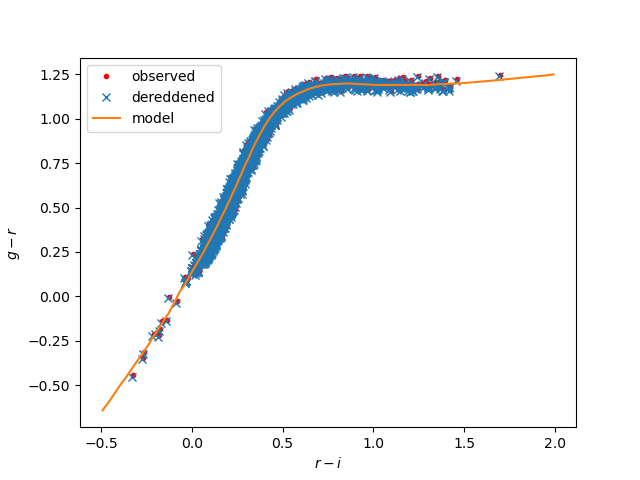

In [4]:
n = name+'_'+str(0)
tab = jobs.get_table(n,format='CSV').to_pandas()
ind = ((tab.gMeanPSFMag.values > -800) & (tab.rMeanPSFMag.values > -800) & 
       (tab.iMeanPSFMag.values > -800) & (tab.zMeanPSFMag.values > -800))
tab = tab.iloc[ind]
e,dat = Tonry_reduce(tab,plot=True)

In [5]:
e

array([0.00860586])

In [7]:
coords = SkyCoord(ra=dat.raMean.values*u.deg,dec=dat.decMean.values*u.deg)
sfd = SFDQuery()
highsfd = sfd(coords) * 0.88

In [8]:
np.nanmedian(e-highsfd)

0.0019560492266715284

<IPython.core.display.Javascript object>


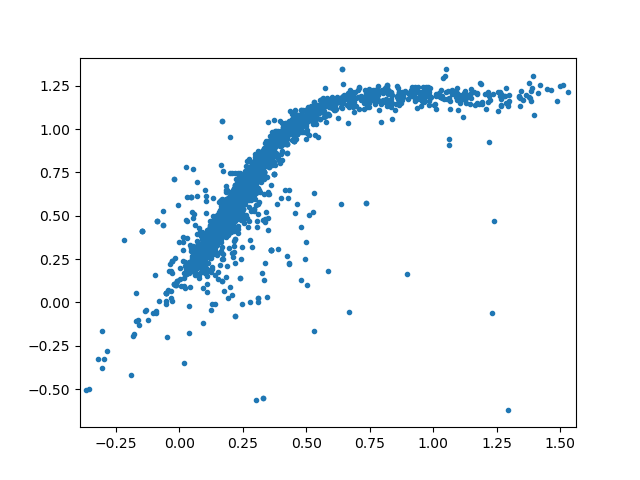

In [24]:
gr = tab.gMeanPSFMag - tab.rMeanPSFMag
ri = tab.rMeanPSFMag - tab.iMeanPSFMag
plt.figure()
plt.plot(ri,gr,'.')

In [72]:
agk = SkyCoord(197.6516250*u.deg,-4.4857417*u.deg)

Making output request for CSV-format data


<IPython.core.display.Javascript object>


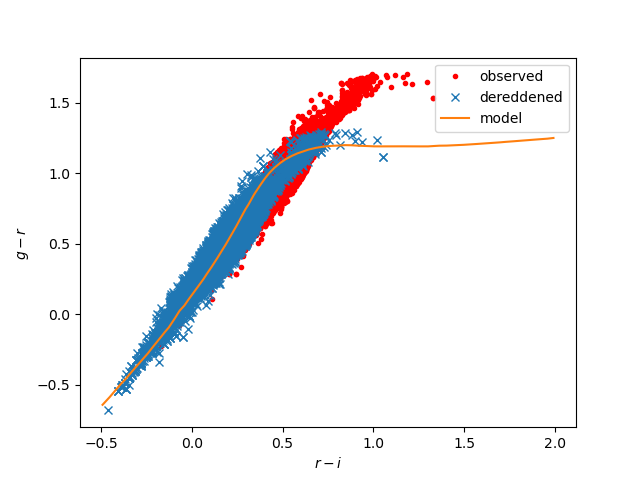

In [15]:
ra = 344.60248 
dec = 59.25243
query = ps1_query.format(dbname=name,ra=ra,
                          dec=dec,rad=0.5*60,
                          band='g',maglim='19')
try:
    jobs.drop_table_if_exists(name)
except:
    pass
jobs.quick(query)
tab = jobs.get_table(name,format='CSV').to_pandas()

ind = ((tab.gMeanPSFMag.values > -800) & (tab.rMeanPSFMag.values > -800) & 
       (tab.iMeanPSFMag.values > -800) & (tab.zMeanPSFMag.values > -800))
tab = tab.iloc[ind]
gr = (tab.gMeanPSFMag - tab.rMeanPSFMag).values
ri = (tab.rMeanPSFMag - tab.iMeanPSFMag).values
e,dat = Tonry_reduce(tab,plot=True)

<IPython.core.display.Javascript object>


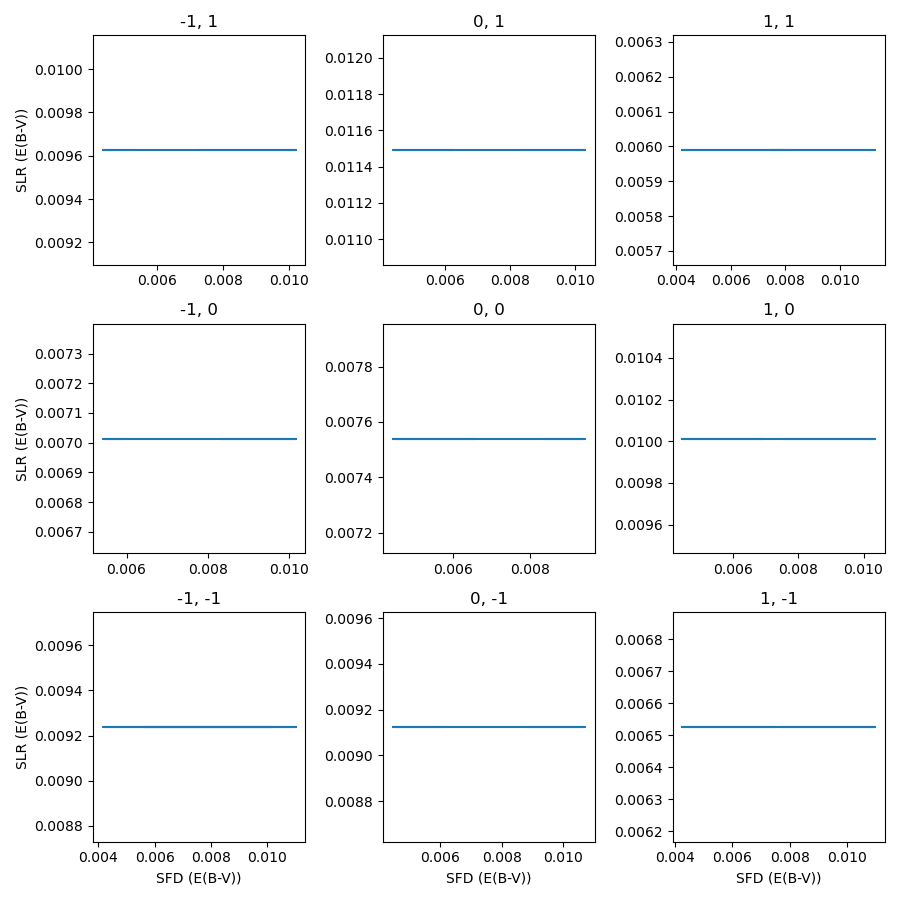

In [43]:
ra = 156.23395
dec = 60.25760

scale = 1
offset = [[-1*scale,1*scale],[0,1*scale],[1*scale,1*scale],
          [-1*scale,0],[0,0],[1*scale,0],
          [-1*scale,-1*scale],[0,-1*scale],[1*scale,-1*scale]]


plt.figure(figsize=(9,9))
for i in range(len(offset)):
    n = name+'_s'+str(i)
    query = ps1_query.format(dbname=n,ra=ra+offset[i][0],
                              dec=dec+offset[i][1],rad=scale/2*60,
                              band='g',maglim='19')
    try:
        #jobs.drop_table_if_exists(name)
        tab = jobs.get_table(n,format='CSV').to_pandas()
    except:
        pass
        jobs.quick(query)
        tab = jobs.get_table(n,format='CSV').to_pandas()
    
    ind = ((tab.gMeanPSFMag.values > -800) & (tab.rMeanPSFMag.values > -800) & 
           (tab.iMeanPSFMag.values > -800) & (tab.zMeanPSFMag.values > -800))
    tab = tab.iloc[ind]
    gr = (tab.gMeanPSFMag - tab.rMeanPSFMag).values
    ri = (tab.rMeanPSFMag - tab.iMeanPSFMag).values
    e,dat = Tonry_reduce(tab,plot=False)
    #e = e / 0.88
    dat.to_csv('extinction/testfield_'+str(i)+'.csv',index=False)
    coords = SkyCoord(ra=dat.raMean.values*u.deg,dec=dat.decMean.values*u.deg)
    sfd = SFDQuery()
    highsfd = sfd(coords)
    
    plt.subplot(3,3,i+1)
    plt.plot(highsfd,e*np.ones(len(highsfd)))
    #plt.axhline(0,color='k',ls='--')
    if (i ==0) | (i ==3)| (i == 6):
        plt.ylabel('SLR (E(B-V))')
    if i > 5:
        plt.xlabel('SFD (E(B-V))')
    plt.title(str(offset[i][0])+', '+ str(offset[i][1]))
plt.tight_layout()
#plt.savefig('SLR_SDF_fields.pdf')

droped
-1, 1


<IPython.core.display.Javascript object>


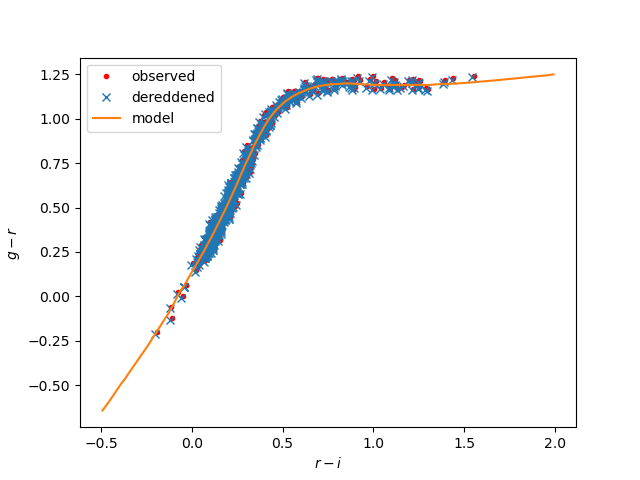

ebv  [0.00962628]
droped
0, 1


<IPython.core.display.Javascript object>


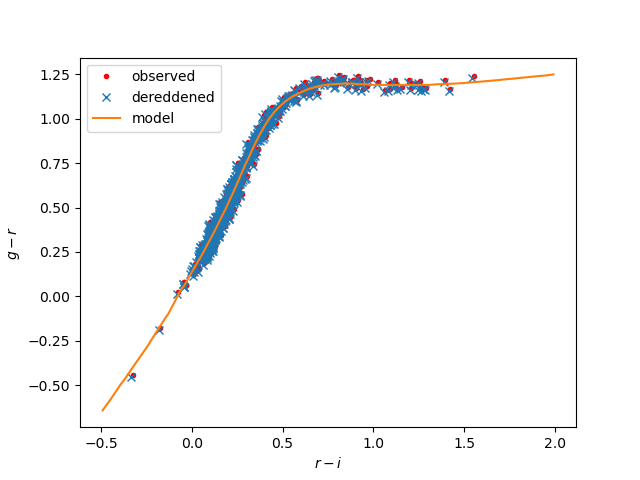

ebv  [0.01149145]
droped
1, 1


<IPython.core.display.Javascript object>


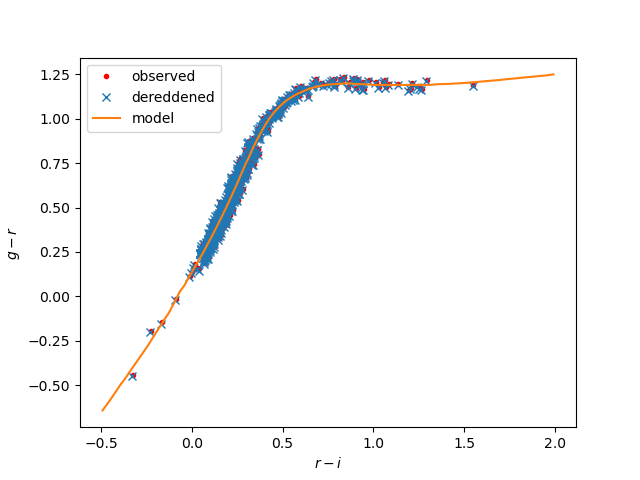

ebv  [0.00598957]
droped
-1, 0


<IPython.core.display.Javascript object>


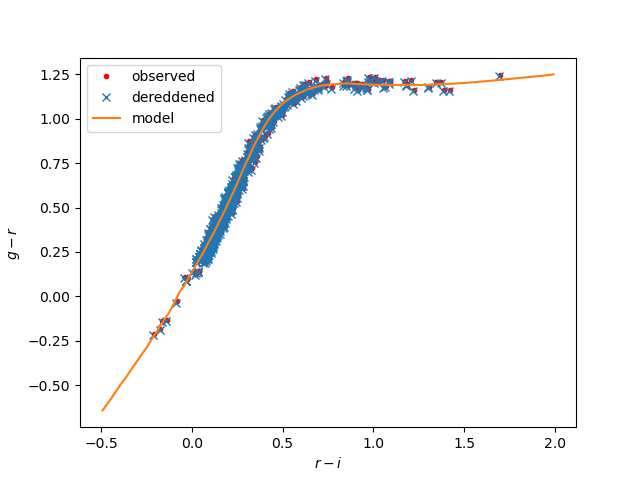

ebv  [0.00701412]
droped
0, 0


<IPython.core.display.Javascript object>


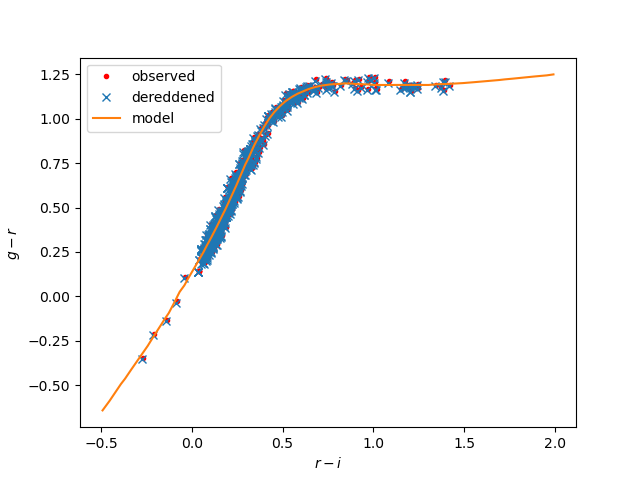

ebv  [0.00753995]
droped
1, 0


<IPython.core.display.Javascript object>


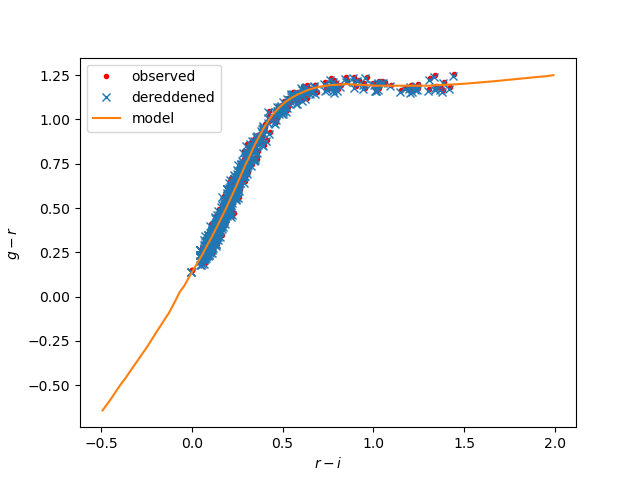

ebv  [0.01001318]
droped
-1, -1


<IPython.core.display.Javascript object>


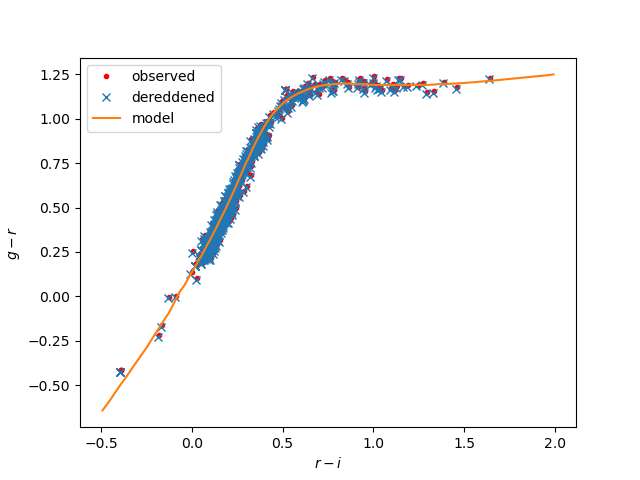

ebv  [0.00923795]
droped
0, -1


<IPython.core.display.Javascript object>


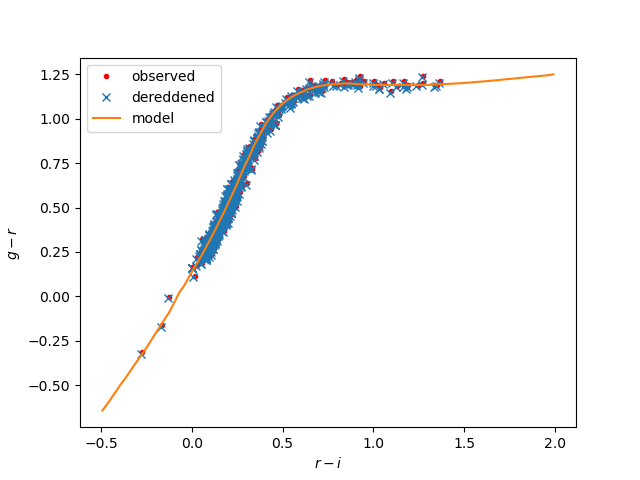

ebv  [0.0091243]
droped
1, -1


<IPython.core.display.Javascript object>


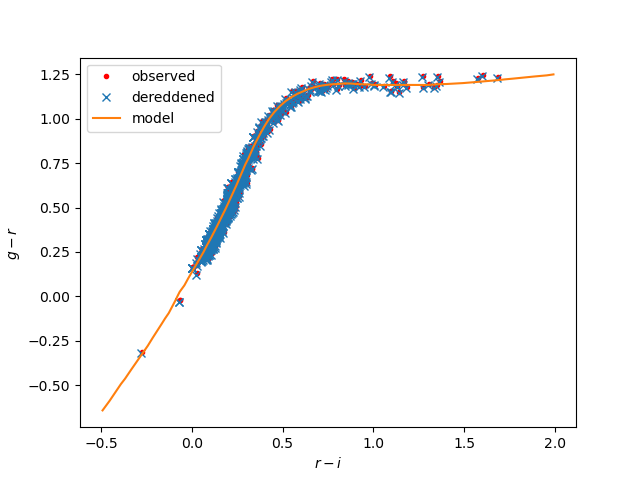

ebv  [0.00652589]


In [42]:
scale = 1
offset = [[-1*scale,1*scale],[0,1*scale],[1*scale,1*scale],
          [-1*scale,0],[0,0],[1*scale,0],
          [-1*scale,-1*scale],[0,-1*scale],[1*scale,-1*scale]]



for i in range(len(offset)):
    n = name+'_s'+str(i)
    query = ps1_query.format(dbname=n,ra=ra+offset[i][0],
                              dec=dec+offset[i][1],rad=scale/2*60,
                              band='g',maglim='19')
    try:
        jobs.drop_table_if_exists(n)
        print('droped')
        jobs.quick(query)
        tab = jobs.get_table(n,format='CSV').to_pandas()
        #tab = jobs.get_table(n,format='CSV').to_pandas()
    except:
        pass
        jobs.quick(query)
        tab = jobs.get_table(n,format='CSV').to_pandas()

    ind = ((tab.gMeanPSFMag.values > -800) & (tab.rMeanPSFMag.values > -800) & 
           (tab.iMeanPSFMag.values > -800) & (tab.zMeanPSFMag.values > -800))
    tab = tab.iloc[ind]
    gr = (tab.gMeanPSFMag - tab.rMeanPSFMag).values
    ri = (tab.rMeanPSFMag - tab.iMeanPSFMag).values
    print(str(offset[i][0])+', '+ str(offset[i][1]))

    e,dat = Tonry_reduce(tab,plot=True)
    print('ebv ',e)

In [20]:
coords = SkyCoord(ra=dat.raMean.values*u.deg,dec=dat.decMean.values*u.deg)
sfd = SFDQuery()
highsfd = sfd(coords) * 0.88

In [21]:
np.nanmedian(e-highsfd)

-1.4131677939265237